# Non-Noise QFT Benchmarking

This notebook loads the noiseless QFT data and produces:
1. **Time vs Shots** at maximum qubit counts  
2. **L₂ Error vs Shots** at maximum qubit counts  
3. **No-Noise Comparison** across qubit counts for a fixed shot count  

## 1. Setup & Styling

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.3,
                rc={"figure.figsize": (10, 6),
                    "axes.linewidth": 1.2,
                    "lines.linewidth": 2.5,
                    "lines.markersize": 8,
                    "legend.frameon": False})
plt.rcParams.update({
    'font.family': 'serif',
    'savefig.format': 'png',
    'figure.dpi': 300
})


## 2. Color & Style Maps

In [12]:
BASE_DIR     = Path().resolve()
DATA_DIR     = BASE_DIR / "data_csv" / "treated_data"
GRAPHS_DIR   = BASE_DIR / "report" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

NOISELESS_CSV = DATA_DIR / "qft_merged_no_noise.csv"

COLOR_MAP = {
    'cudaq-gpu': '#1f77b4',
    'cudaq-cpu': '#2ca02c',
    'qiskit-gpu': '#d62728',
    'qiskit-cpu': '#ff7f0e'
}
STYLE_MAP = {
    'zero': {'linestyle': '-',  'marker': 'o'},
    'ghz':  {'linestyle': '--', 'marker': 'x'}
}


## 3. Time vs Shots and L2 Error vs Shots at max qubit count


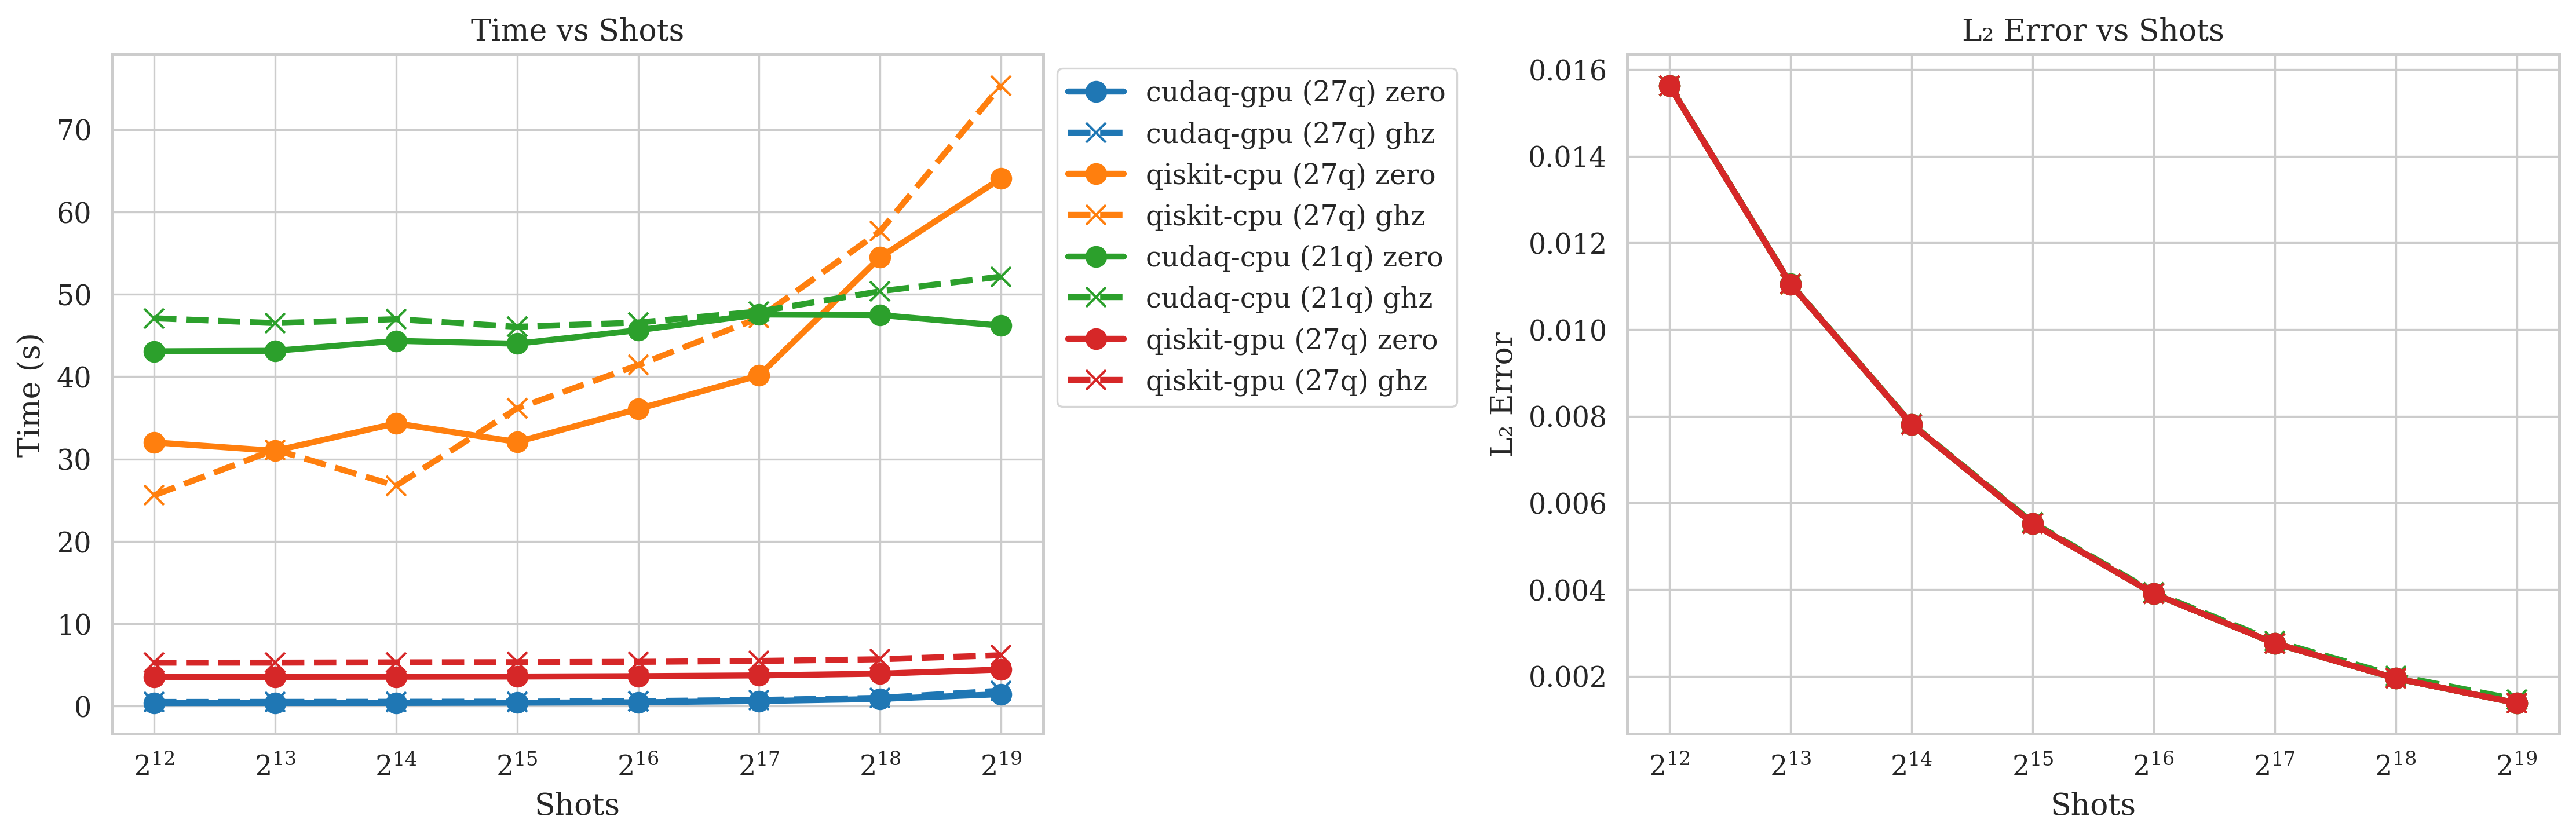

In [13]:
def plot_shot_vs_time_l2_max_qubits():
    df = pd.read_csv(NOISELESS_CSV)
    shots = [4096,8192,16384,32768,65536,131072,262144,524288]
    df = df[df.shots.isin(shots)]

    # find max common n_bits with both inits
    common_max = (
        df.groupby(['target','init'])['n_bits']
          .max().unstack().dropna()
          .min(axis=1).reset_index().rename(columns={0:'n_bits'})
    )
    dfm = pd.merge(df, common_max, on=['target','n_bits'])

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5), sharex=True)
    for sim in dfm.target.unique():
        nq = int(dfm[dfm.target==sim]['n_bits'].iloc[0])
        for init in ['zero','ghz']:
            sub = dfm[(dfm.target==sim)&(dfm.init==init)]
            ax1.plot(sub.shots, sub.sim_time_s,
                     label=f'{sim} ({nq}q) {init}',
                     color=COLOR_MAP[sim],
                     linestyle=STYLE_MAP[init]['linestyle'],
                     marker=STYLE_MAP[init]['marker'])
            ax2.plot(sub.shots, sub.l2_error,
                     color=COLOR_MAP[sim],
                     linestyle=STYLE_MAP[init]['linestyle'],
                     marker=STYLE_MAP[init]['marker'])

    ax1.set_xscale('log', base=2)
    ax1.set(xlabel='Shots', ylabel='Time (s)', title='Time vs Shots')
    ax1.legend(loc='upper left', bbox_to_anchor=(1,1))

    ax2.set_xscale('log', base=2)
    ax2.set(xlabel='Shots', ylabel='L₂ Error', title='L₂ Error vs Shots')
    if ax2.get_legend(): ax2.get_legend().remove()

    plt.tight_layout()
    out = GRAPHS_DIR / 'shot_vs_time_l2_max_qubits.png'
    fig.savefig(out)
    plt.show()

plot_shot_vs_time_l2_max_qubits()

## No-Noise Comparison @ 131,072 shots

In [14]:
def plot_no_noise_comparison(shots=131072):
    df = pd.read_csv(NOISELESS_CSV)
    df = df[df.shots==shots]
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    for (t,i), g in df.groupby(['target','init']):
        grp = g.sort_values('n_bits')
        ax1.plot(grp.n_bits, grp.sim_time_s,
                 label=f'{t} {i}',
                 color=COLOR_MAP[t],
                 linestyle=STYLE_MAP[i]['linestyle'],
                 marker=STYLE_MAP[i]['marker'])
        ax2.plot(grp.n_bits, grp.l2_error,
                 label=f'{t} {i}',
                 color=COLOR_MAP[t],
                 linestyle=STYLE_MAP[i]['linestyle'],
                 marker=STYLE_MAP[i]['marker'])

    ax1.set(xlabel='Qubits', ylabel='Time (s)',
            title=f'Time vs Qubits ({shots} shots)')
    ax2.set(xlabel='Qubits', ylabel='L₂ Error',
            title=f'L₂ Error vs Qubits ({shots} shots)')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    out = GRAPHS_DIR / f'no_noise_comparison_{shots}.png'
    fig.savefig(out)
    plt.show()

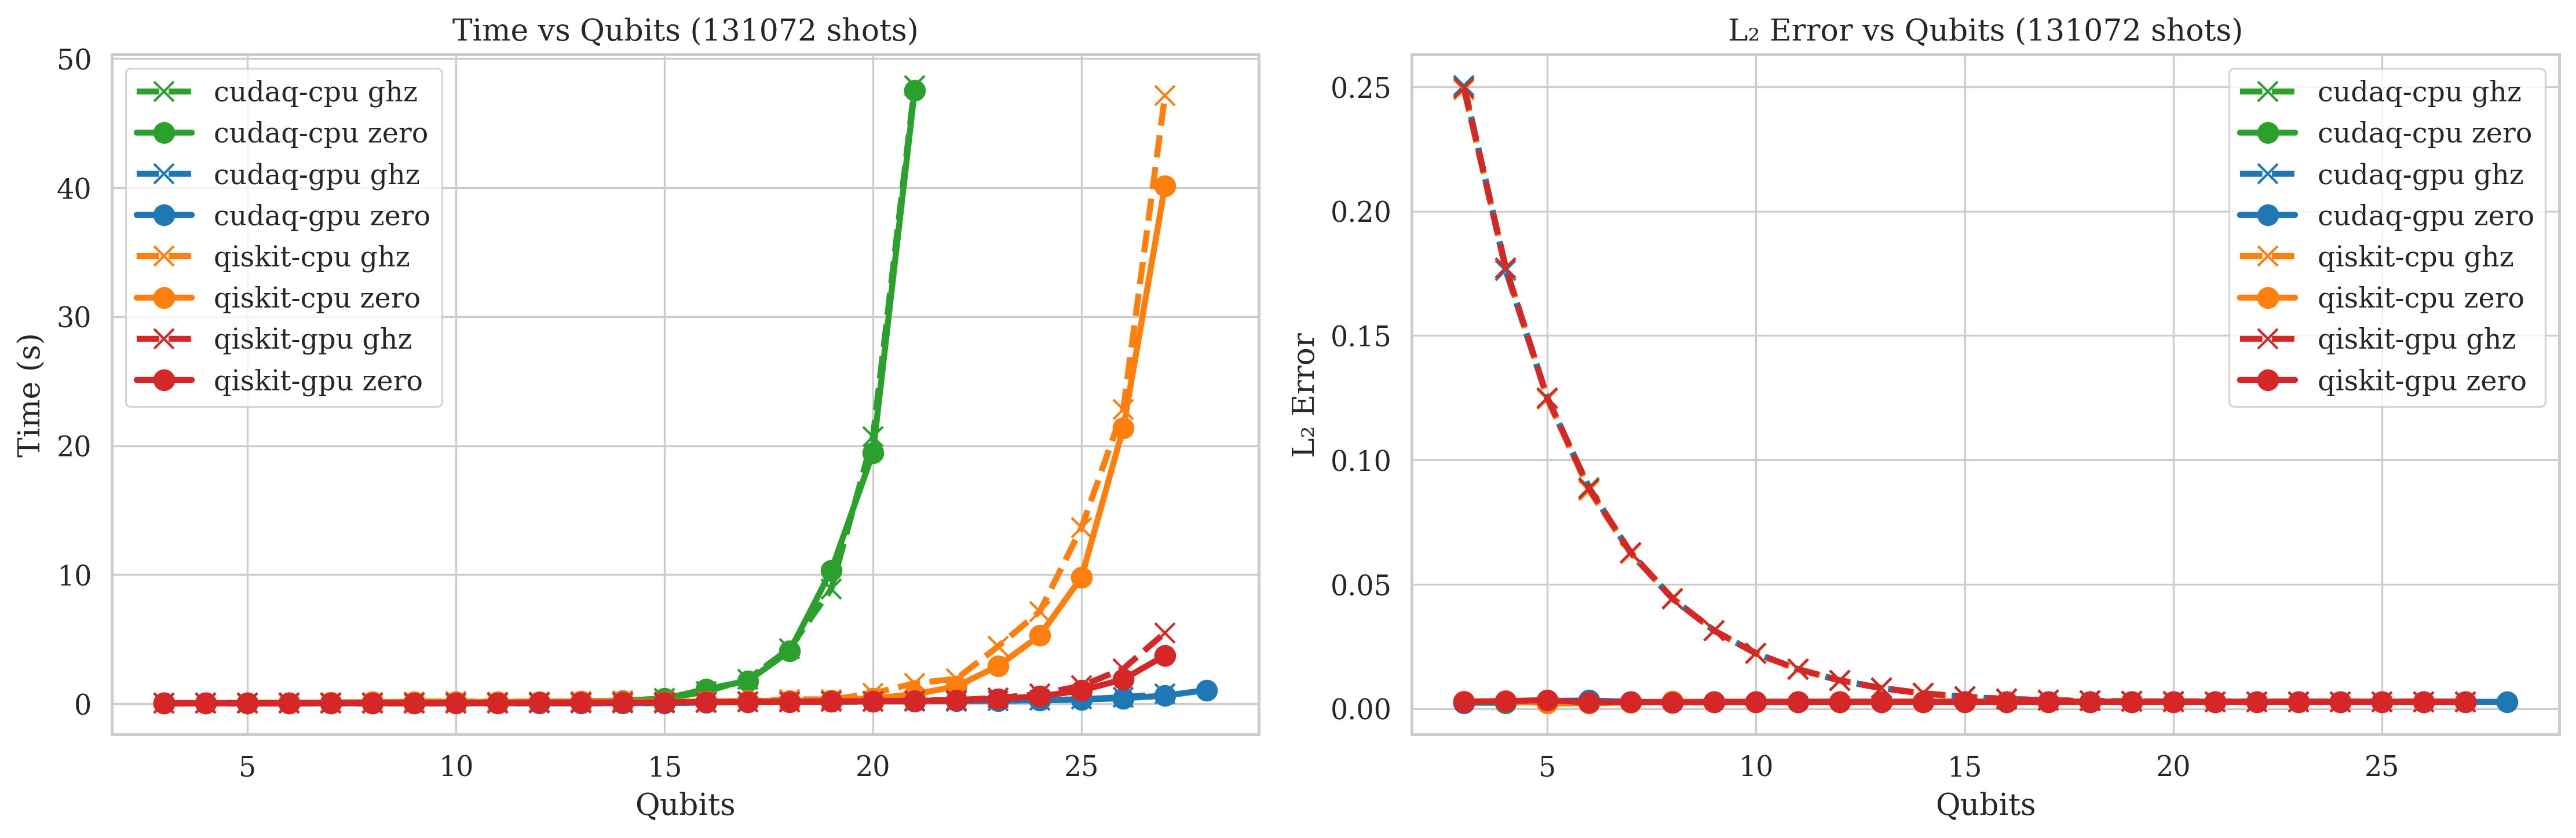

In [15]:
shots = 2**17
plot_no_noise_comparison(shots)

# Noise-Injected QFT Benchmarking

This notebook loads the noisy QFT data and produces:
1. **Δ Fidelity (CUDA-Q vs Qiskit)**  
2. **Noise-Qu bit Evolution** for fidelity, L₂ error, Frobenius norm & time 

## Paths & Style Maps

In [16]:
BASE_DIR   = Path().resolve()
DATA_DIR   = BASE_DIR / "data_csv" / "treated_data"
GRAPHS_DIR = BASE_DIR / "report" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

NOISE_CSV = DATA_DIR / "qft_merged_noise.csv"

COLOR_MAP = {
    'cudaq-gpu': '#1f77b4',
    'cudaq-cpu': '#2ca02c',
    'qiskit-gpu': '#d62728',
    'qiskit-cpu': '#ff7f0e'
}

Δ Fidelity Composite

In [17]:
def plot_delta_fidelity_composite():
    df = pd.read_csv(NOISE_CSV)
    df = df[(df.init=='zero') & (df.shots==131072)
             & df.target.isin(['qiskit-cpu','cudaq-cpu'])
             & df.probability.isin([0.01,0.1,0.5])]

    q = df[df.target=='qiskit-cpu'][['noise','probability','n_bits','fidelity']].rename(columns={'fidelity':'fq'})
    c = df[df.target=='cudaq-cpu'][['noise','probability','n_bits','fidelity']].rename(columns={'fidelity':'fc'})
    dfm = pd.merge(q, c, on=['noise','probability','n_bits'])
    dfm['delta'] = dfm.fc - dfm.fq

    avg = dfm.groupby('noise')['delta'].mean().reset_index()
    cmap = dict(zip(avg.noise, sns.color_palette('tab10', n_colors=len(avg))))

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6), gridspec_kw={'width_ratios':[2,1]})
    sns.lineplot(data=dfm, x='n_bits', y='delta', hue='noise', style='probability',
                 dashes={0.01:'',0.1:(5,3),0.5:(1,1)}, markers={0.01:'o',0.1:'s',0.5:'D'},
                 palette=cmap, ax=ax1)
    ax1.axhline(0, color='gray', linestyle='--')
    ax1.set(xlabel='Qubits', ylabel='Δ Fidelity', title='Δ Fidelity (CUDA-Q − Qiskit)')
    ax1.legend(title='Noise / p', loc='upper left', bbox_to_anchor=(1,1))

    ax2.bar(avg.noise, avg.delta, color=[cmap[n] for n in avg.noise], edgecolor='k')
    ax2.set(xlabel='Noise Model', ylabel='Mean Δ Fidelity', title='Average Δ Fidelity')
    for i, v in enumerate(avg.delta):
        ax2.text(i, v+0.01, f'{v:.2f}', ha='center', va='bottom')
    ax2.tick_params(axis='x', rotation=30)

    plt.tight_layout()
    out = GRAPHS_DIR / 'delta_fidelity_composite.png'
    fig.savefig(out)
    plt.show()

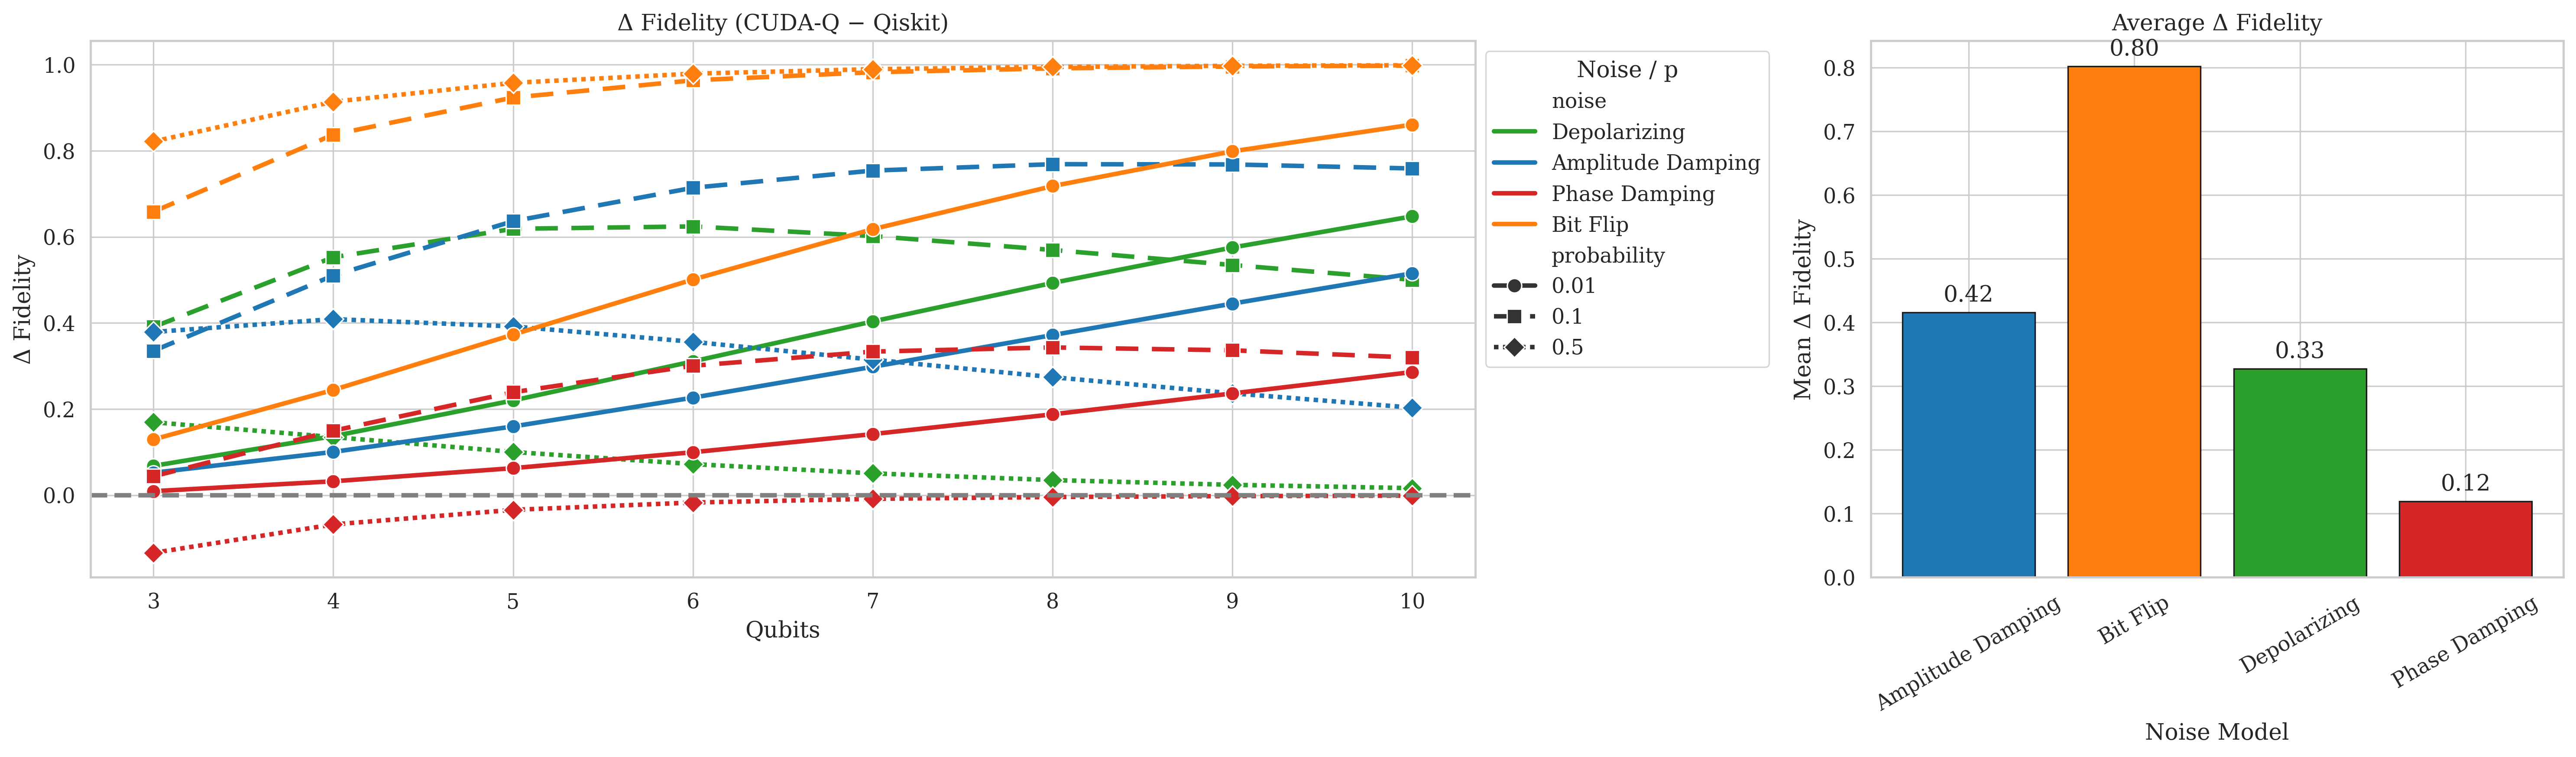

In [18]:
plot_delta_fidelity_composite()

Noise-Qubit Evolution

In [19]:
def plot_noise_qubit_evolution(sim='cudaq-cpu', shots=131072):
    df = pd.read_csv(NOISE_CSV)
    df = df[(df.target==sim)&(df.shots==shots)&df.probability.isin([0.01,0.1,0.5])]

    metrics = [
        ('fidelity', 'Fidelity', (0,1.05)),
        ('l2_error', 'L₂ Error', None),
        ('fro_norm', 'Fro Norm', None),
        ('time_sampling', 'Time (s)', None),
    ]

    for init in ['zero','ghz']:
        subset = df[df.init==init]
        out_dir = GRAPHS_DIR / 'noise_qubit_evolution' / init
        out_dir.mkdir(parents=True, exist_ok=True)

        for col,label,ylim in metrics:
            fig, ax = plt.subplots(figsize=(12,6))
            sns.lineplot(data=subset, x='n_bits', y=col,
                         hue='noise', style='probability',
                         markers=True, dashes=True, ax=ax)
            ax.set(xlabel='Qubits', ylabel=label,
                   title=f'{label} vs Qubits ({sim}, init={init})')
            if ylim: ax.set_ylim(*ylim)
            ax.legend(title='Noise / p', loc='upper left', bbox_to_anchor=(1,1))

            plt.tight_layout()
            out = out_dir / f'{col}_{sim}_{init}_{shots}.png'
            fig.savefig(out)
            plt.show()

### CUDA-Q

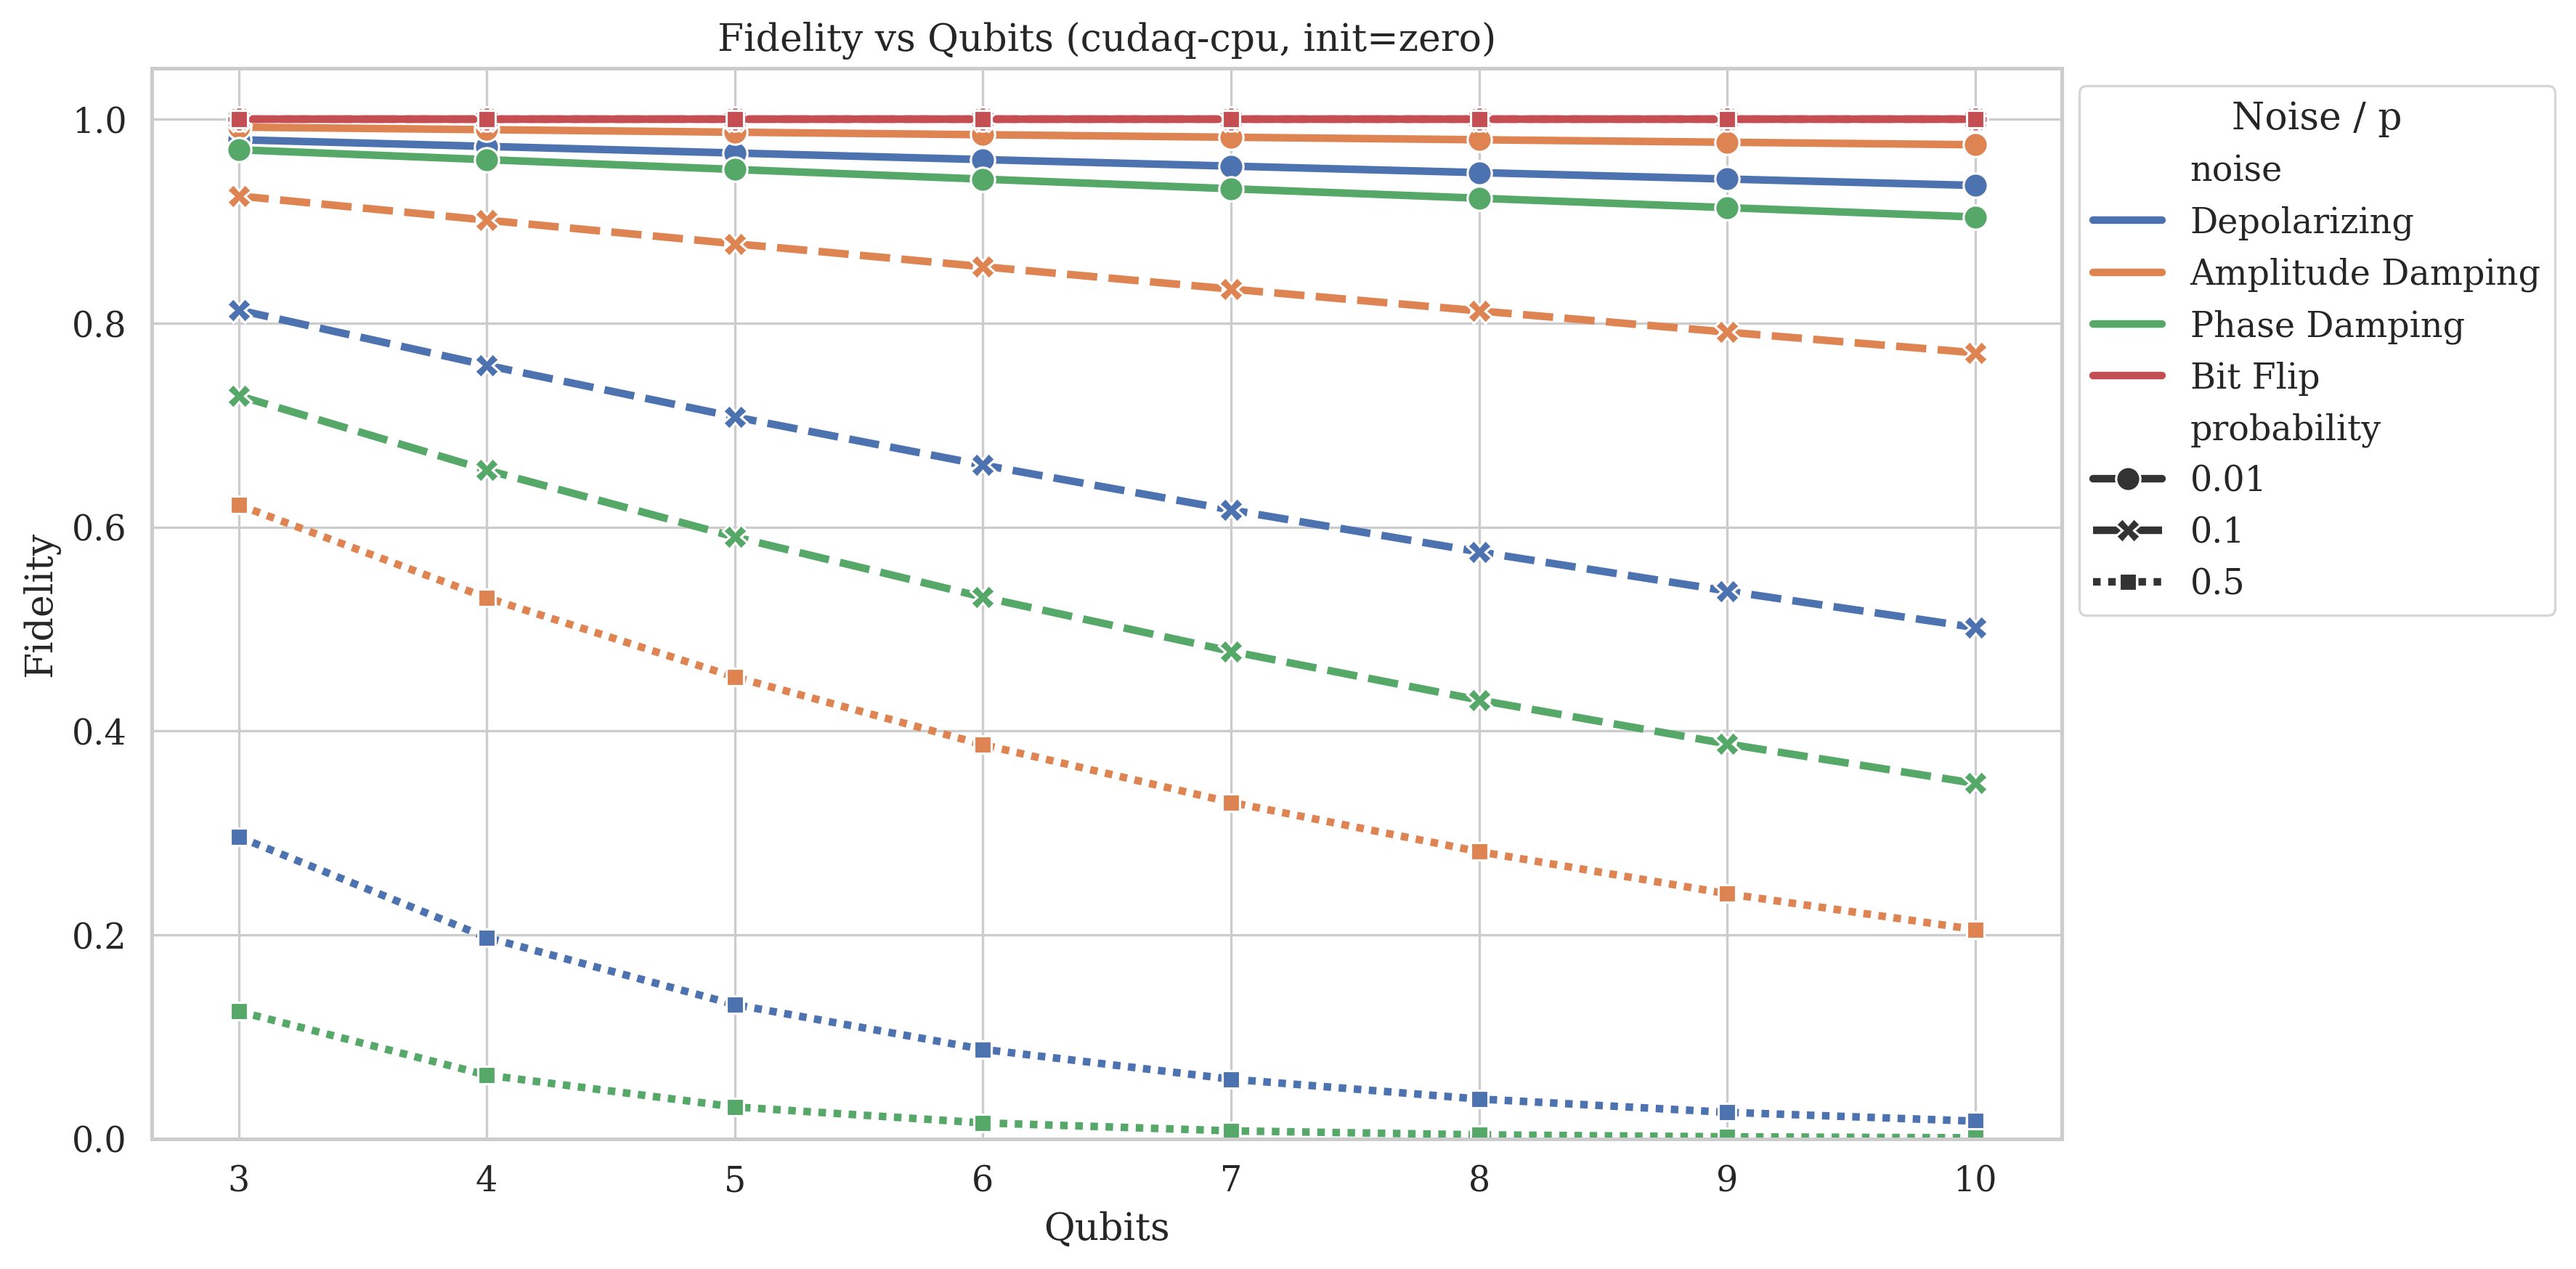

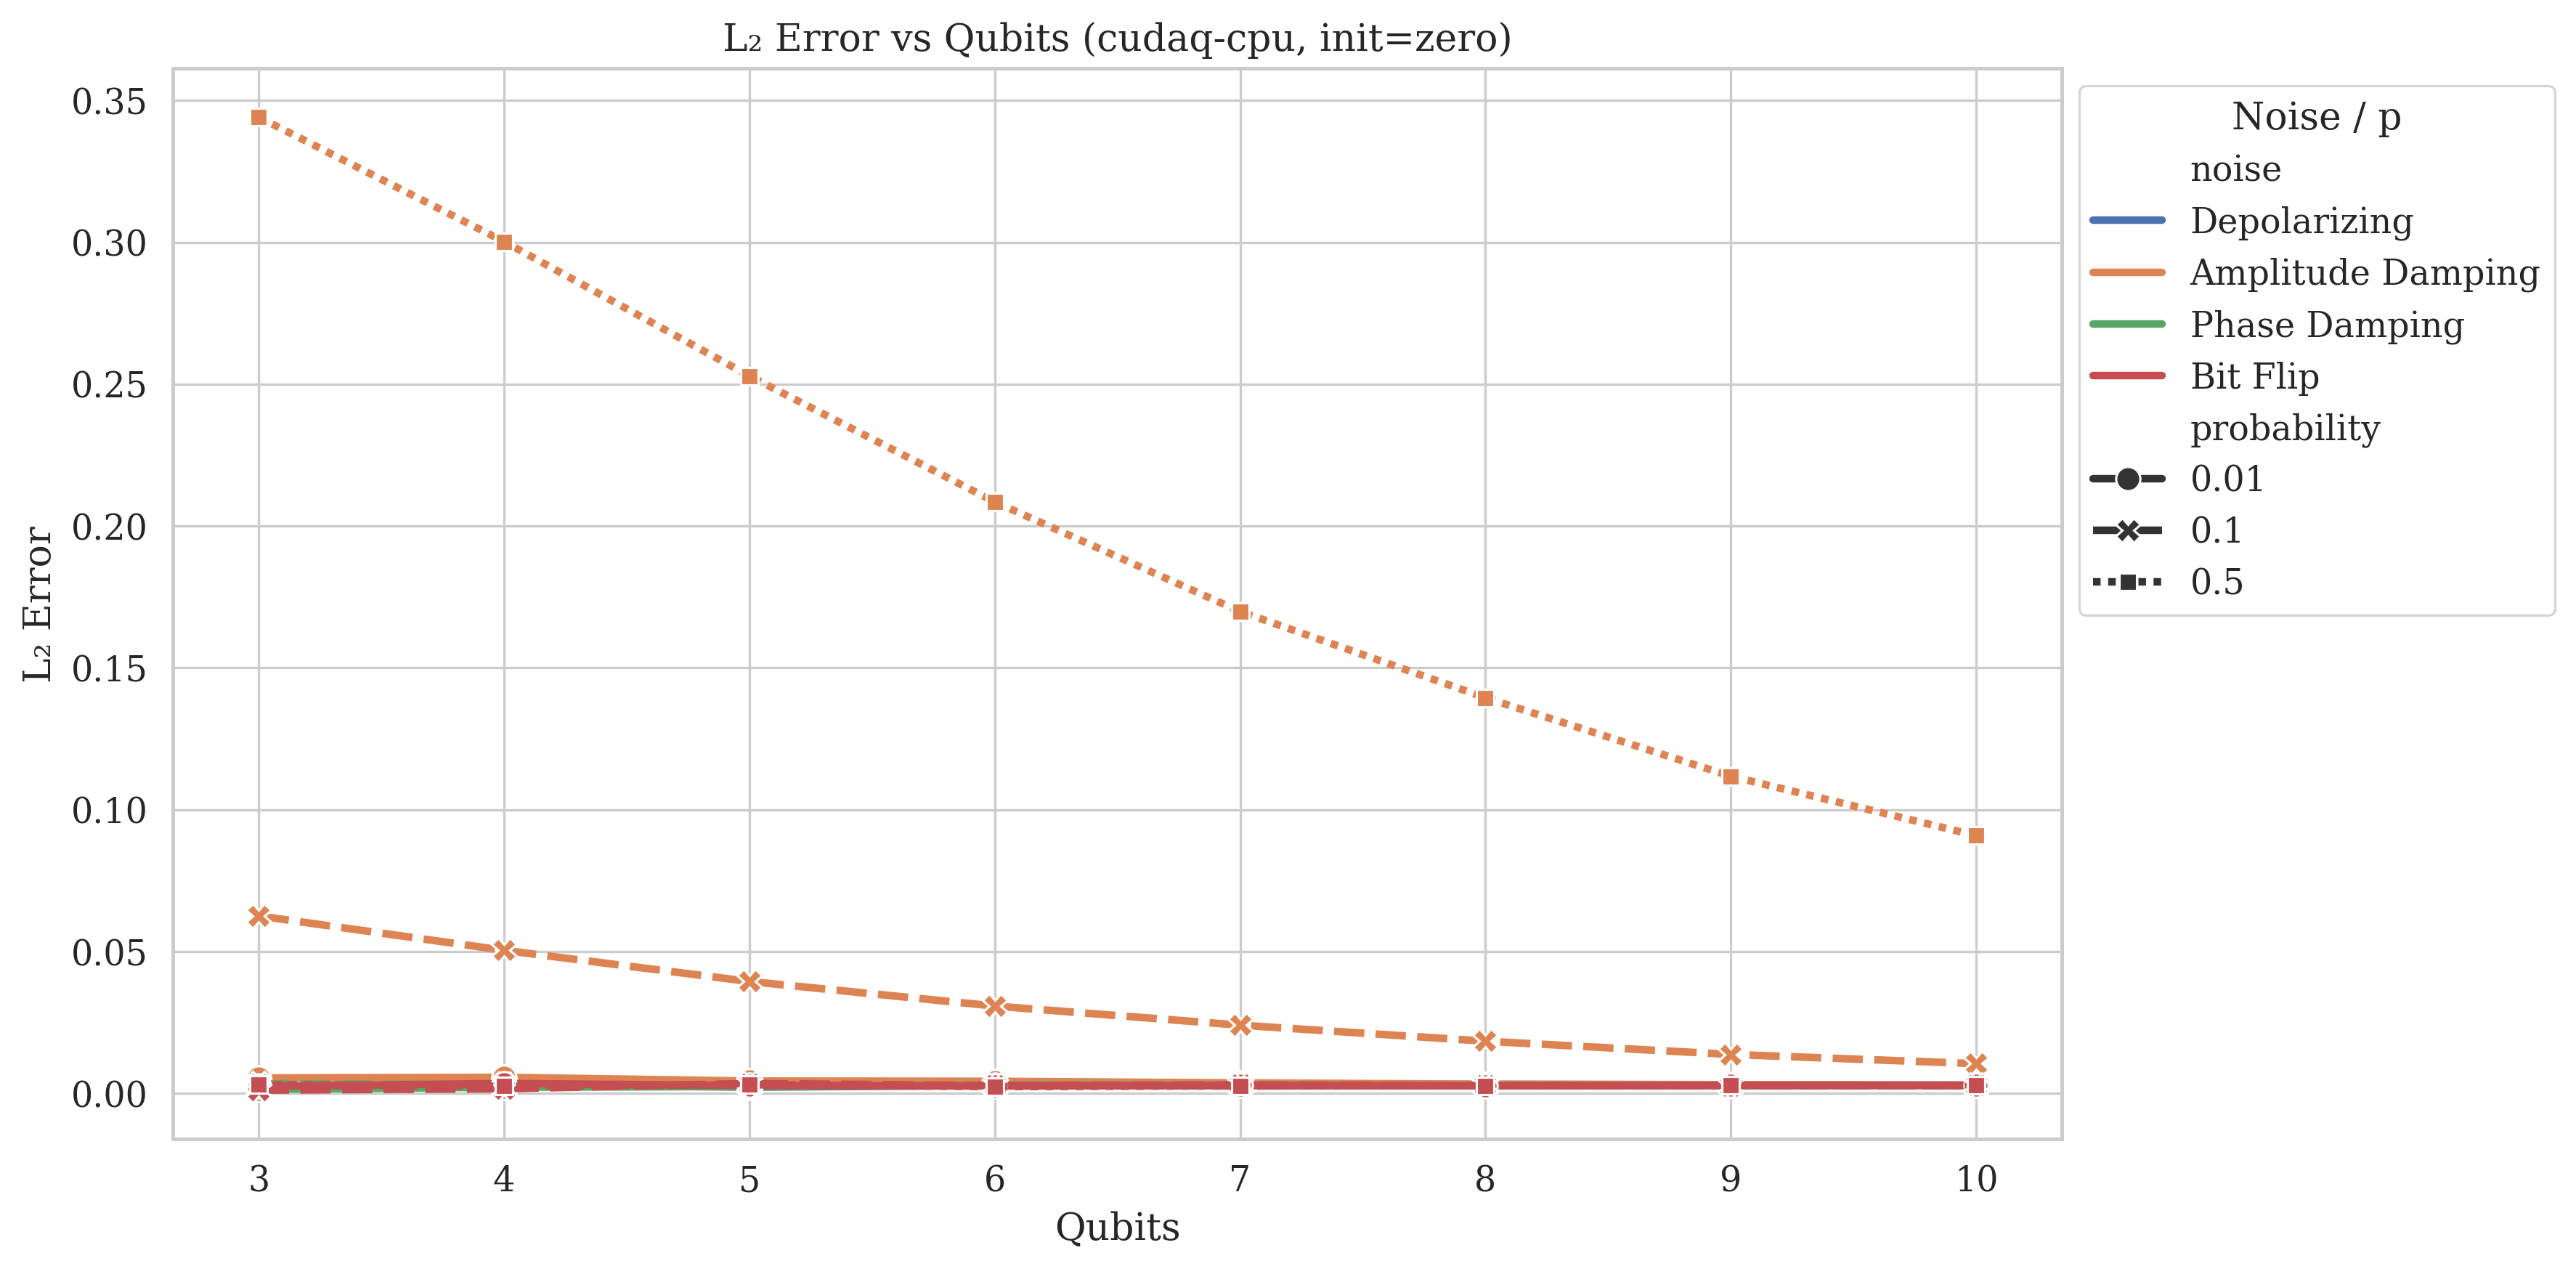

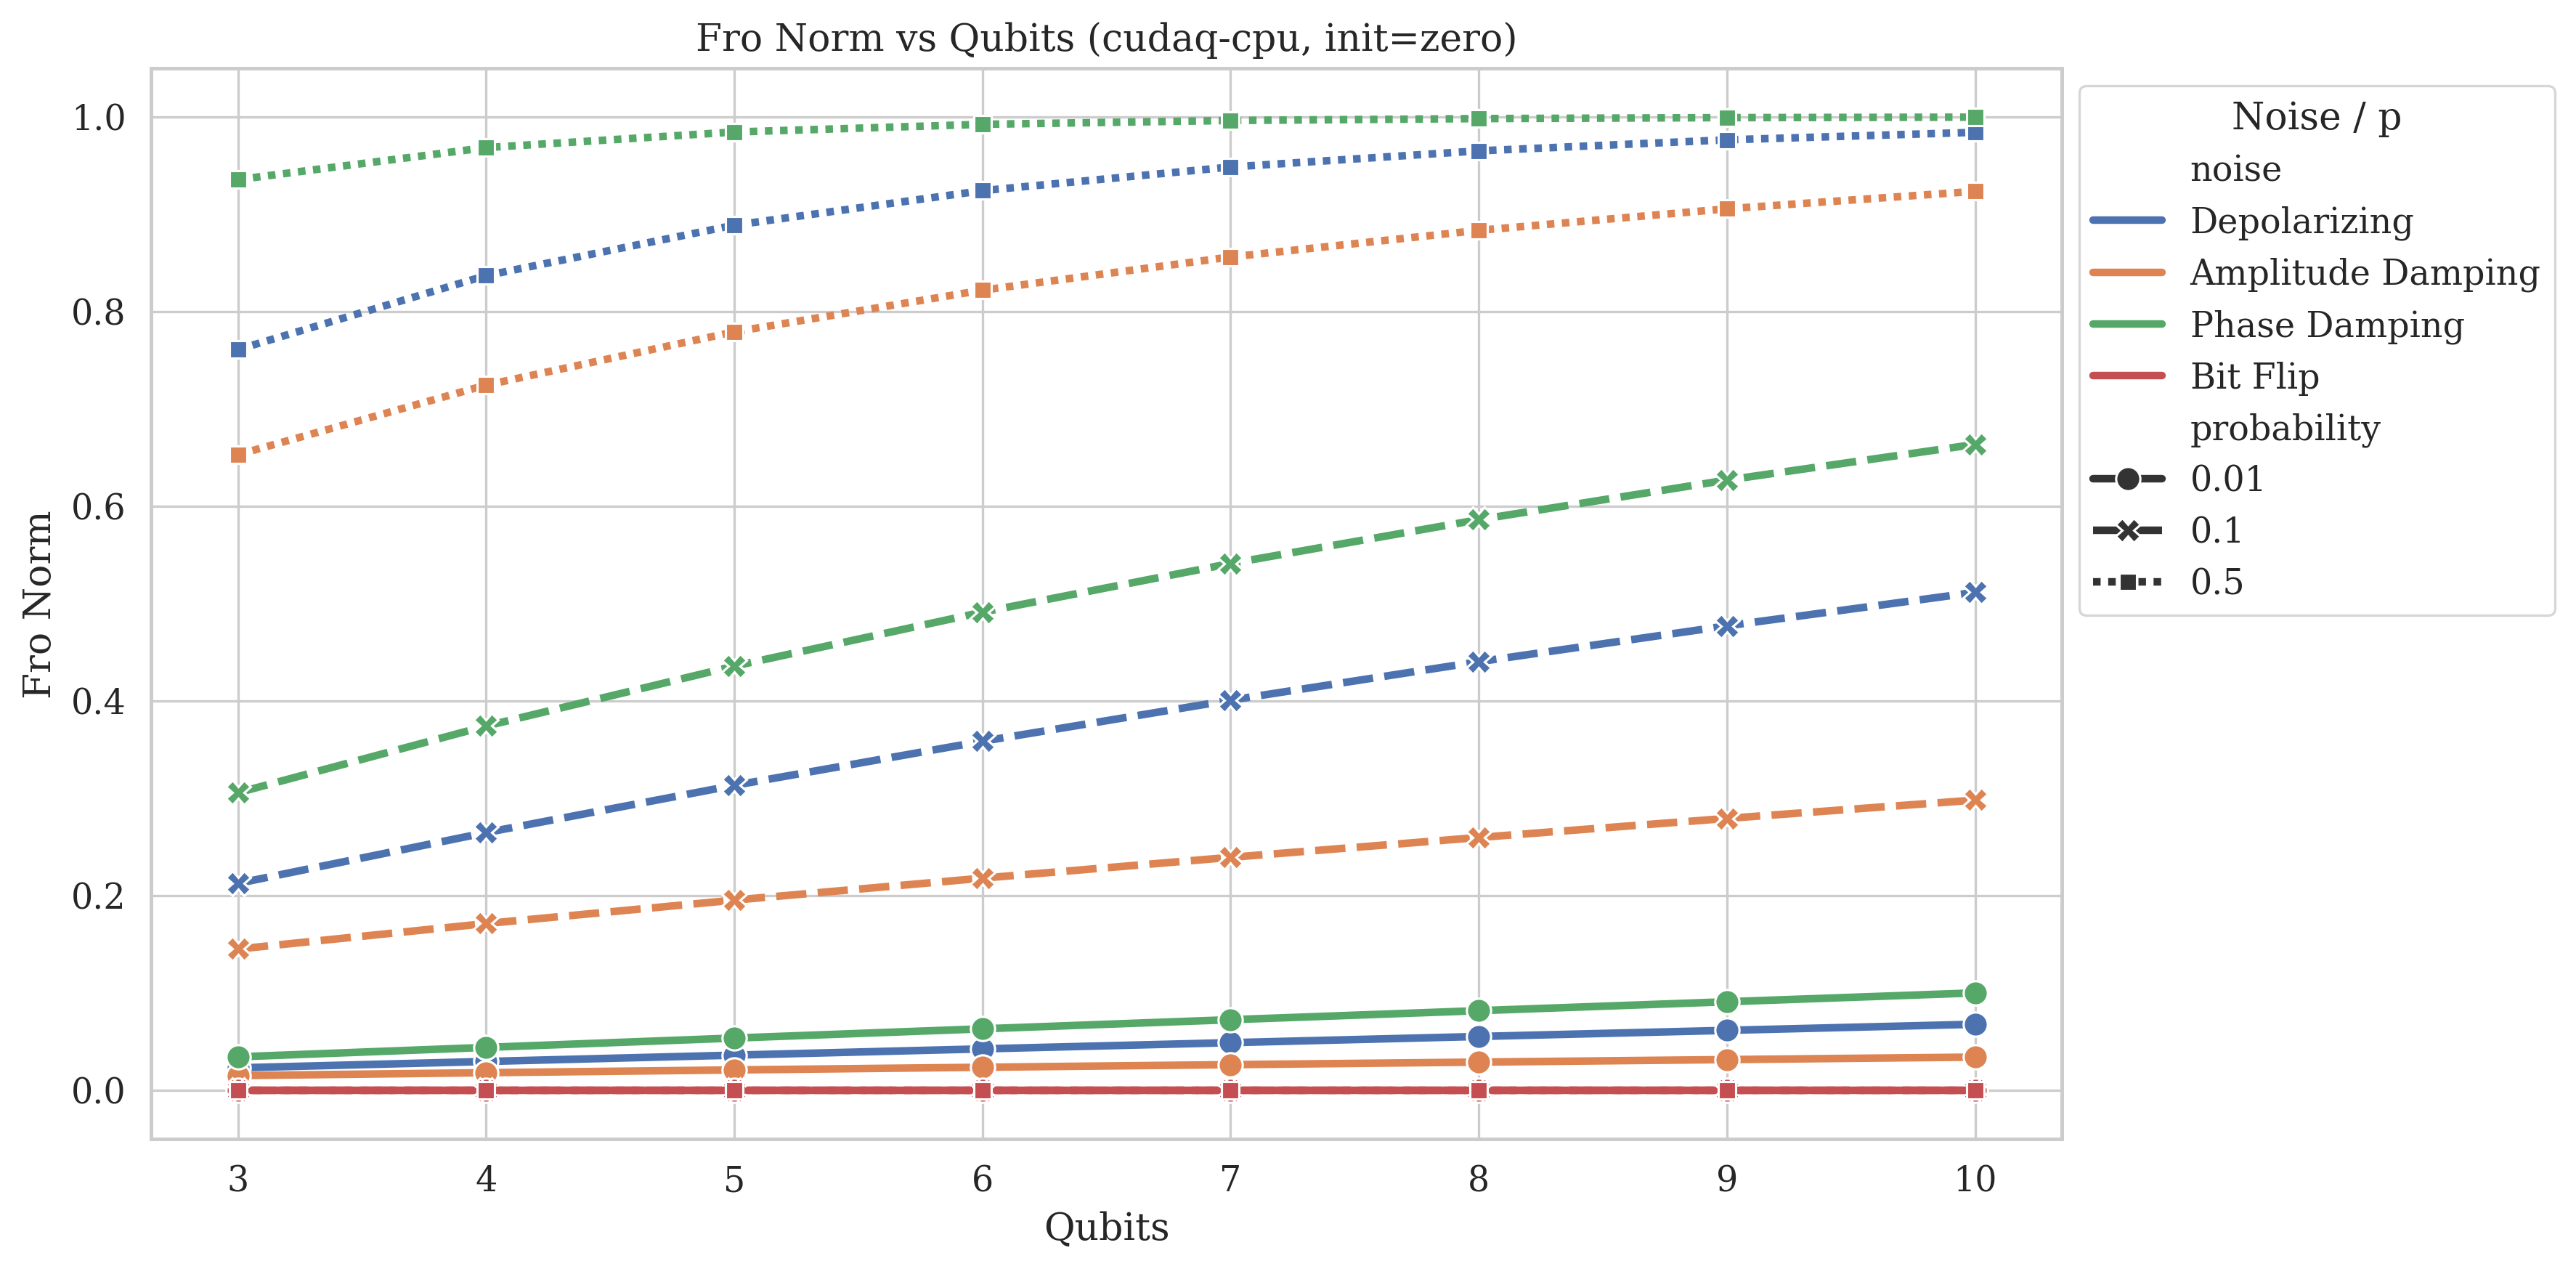

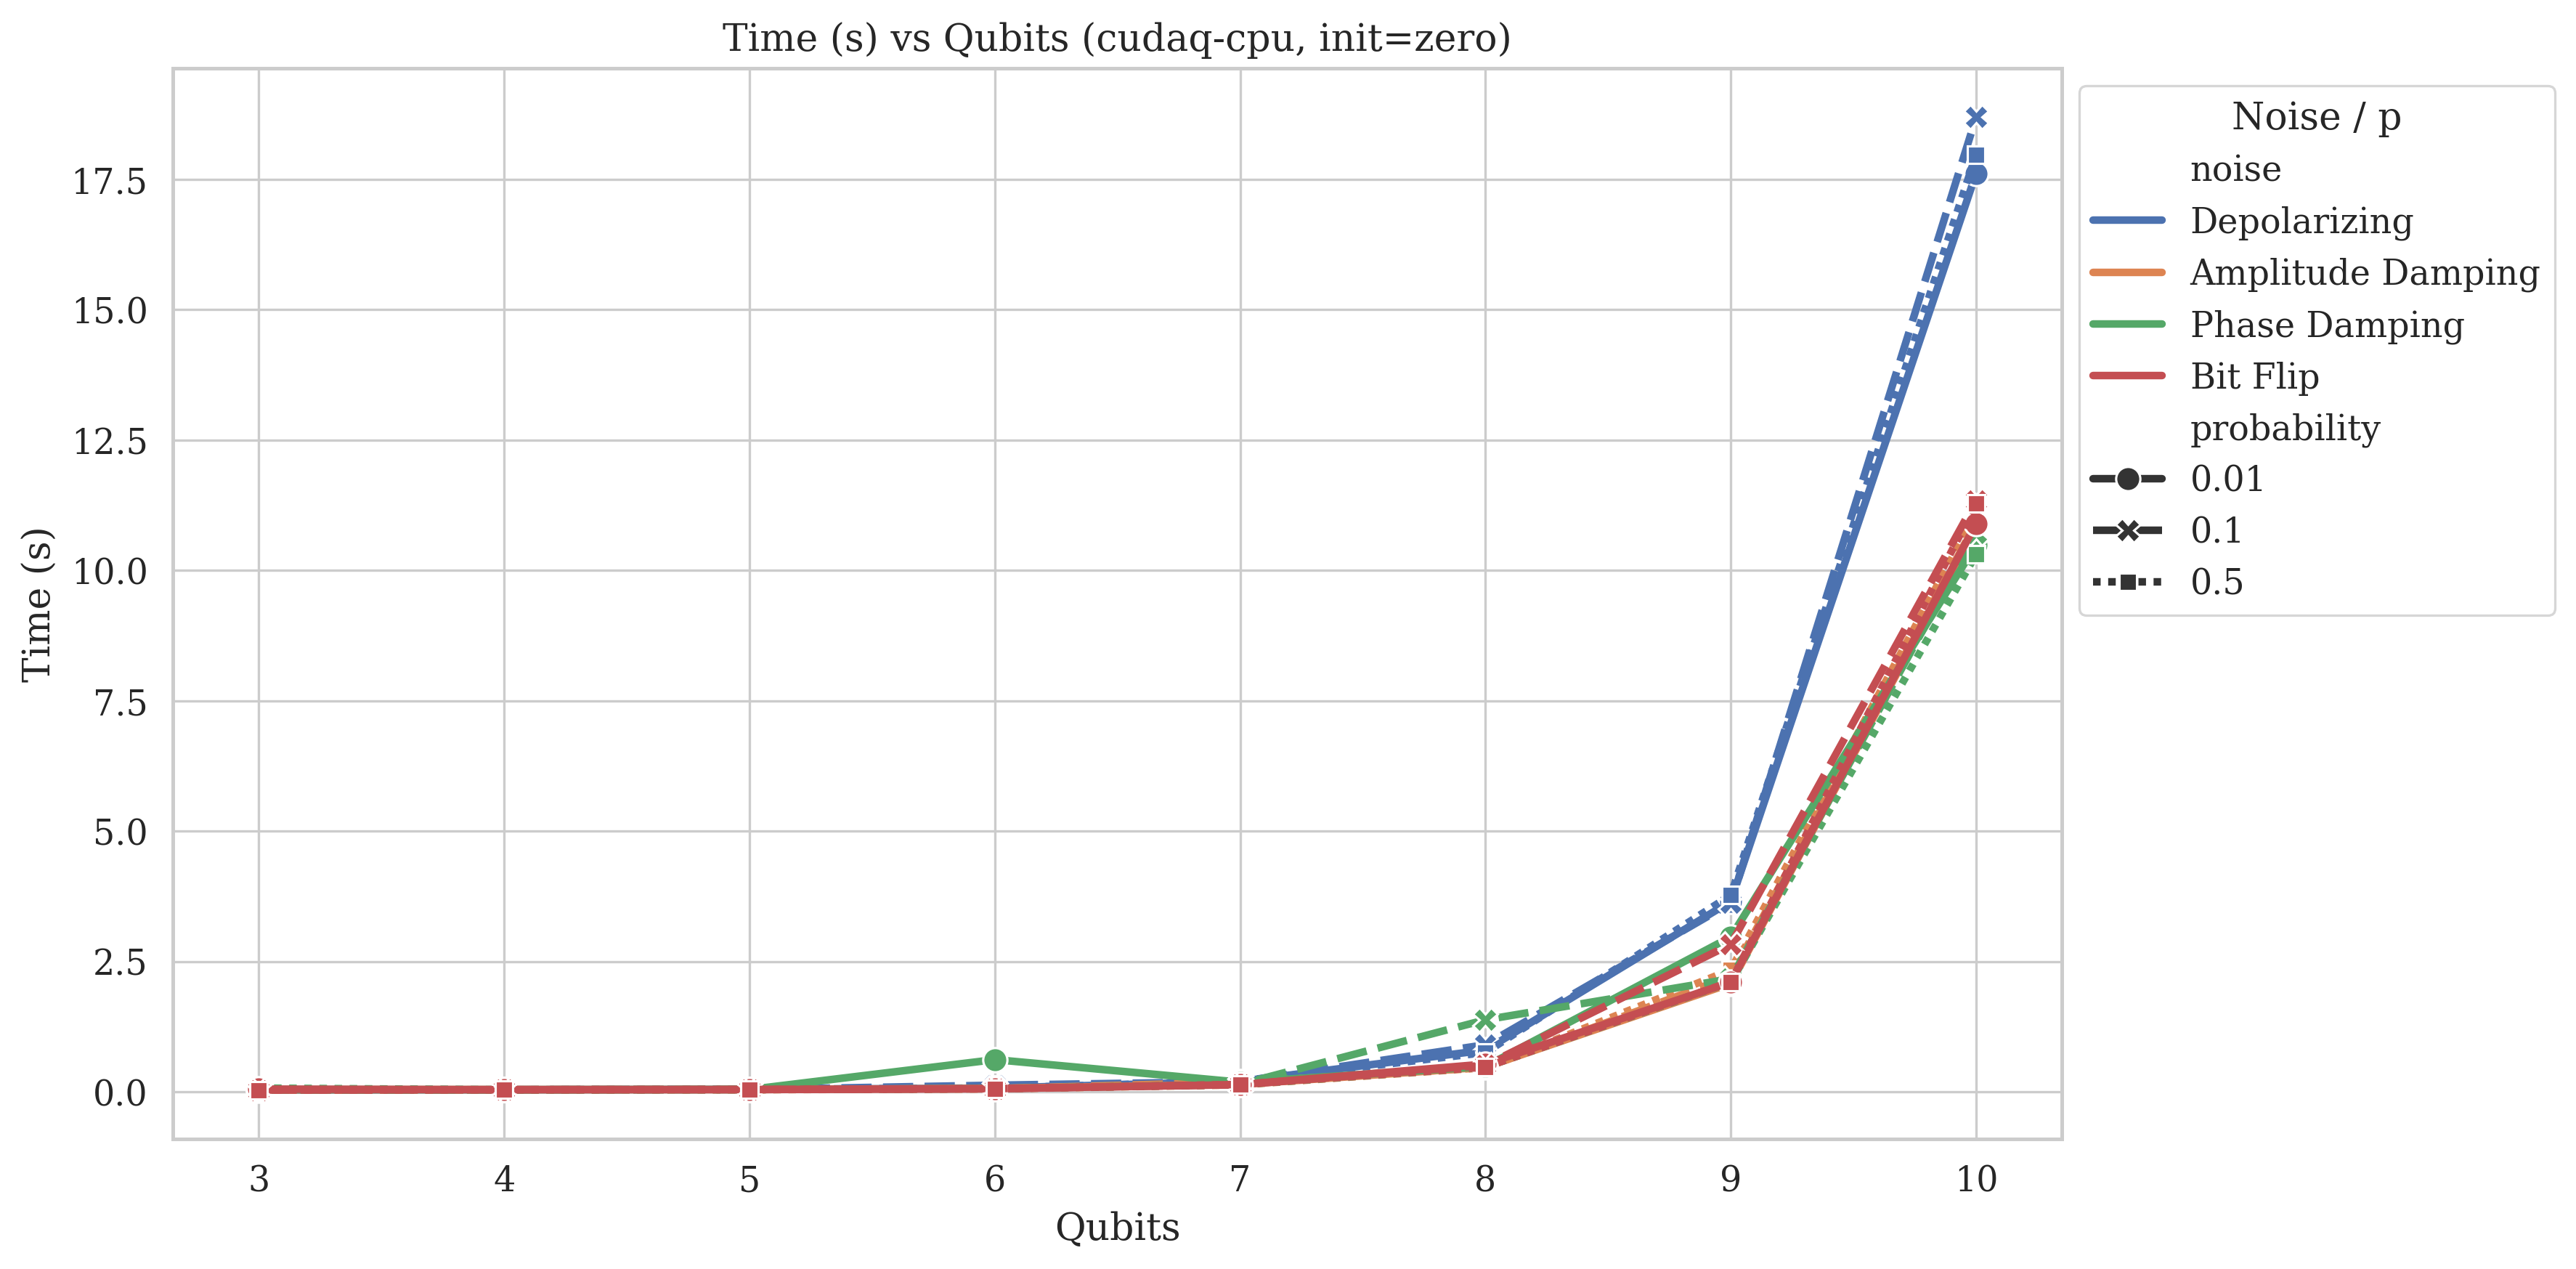

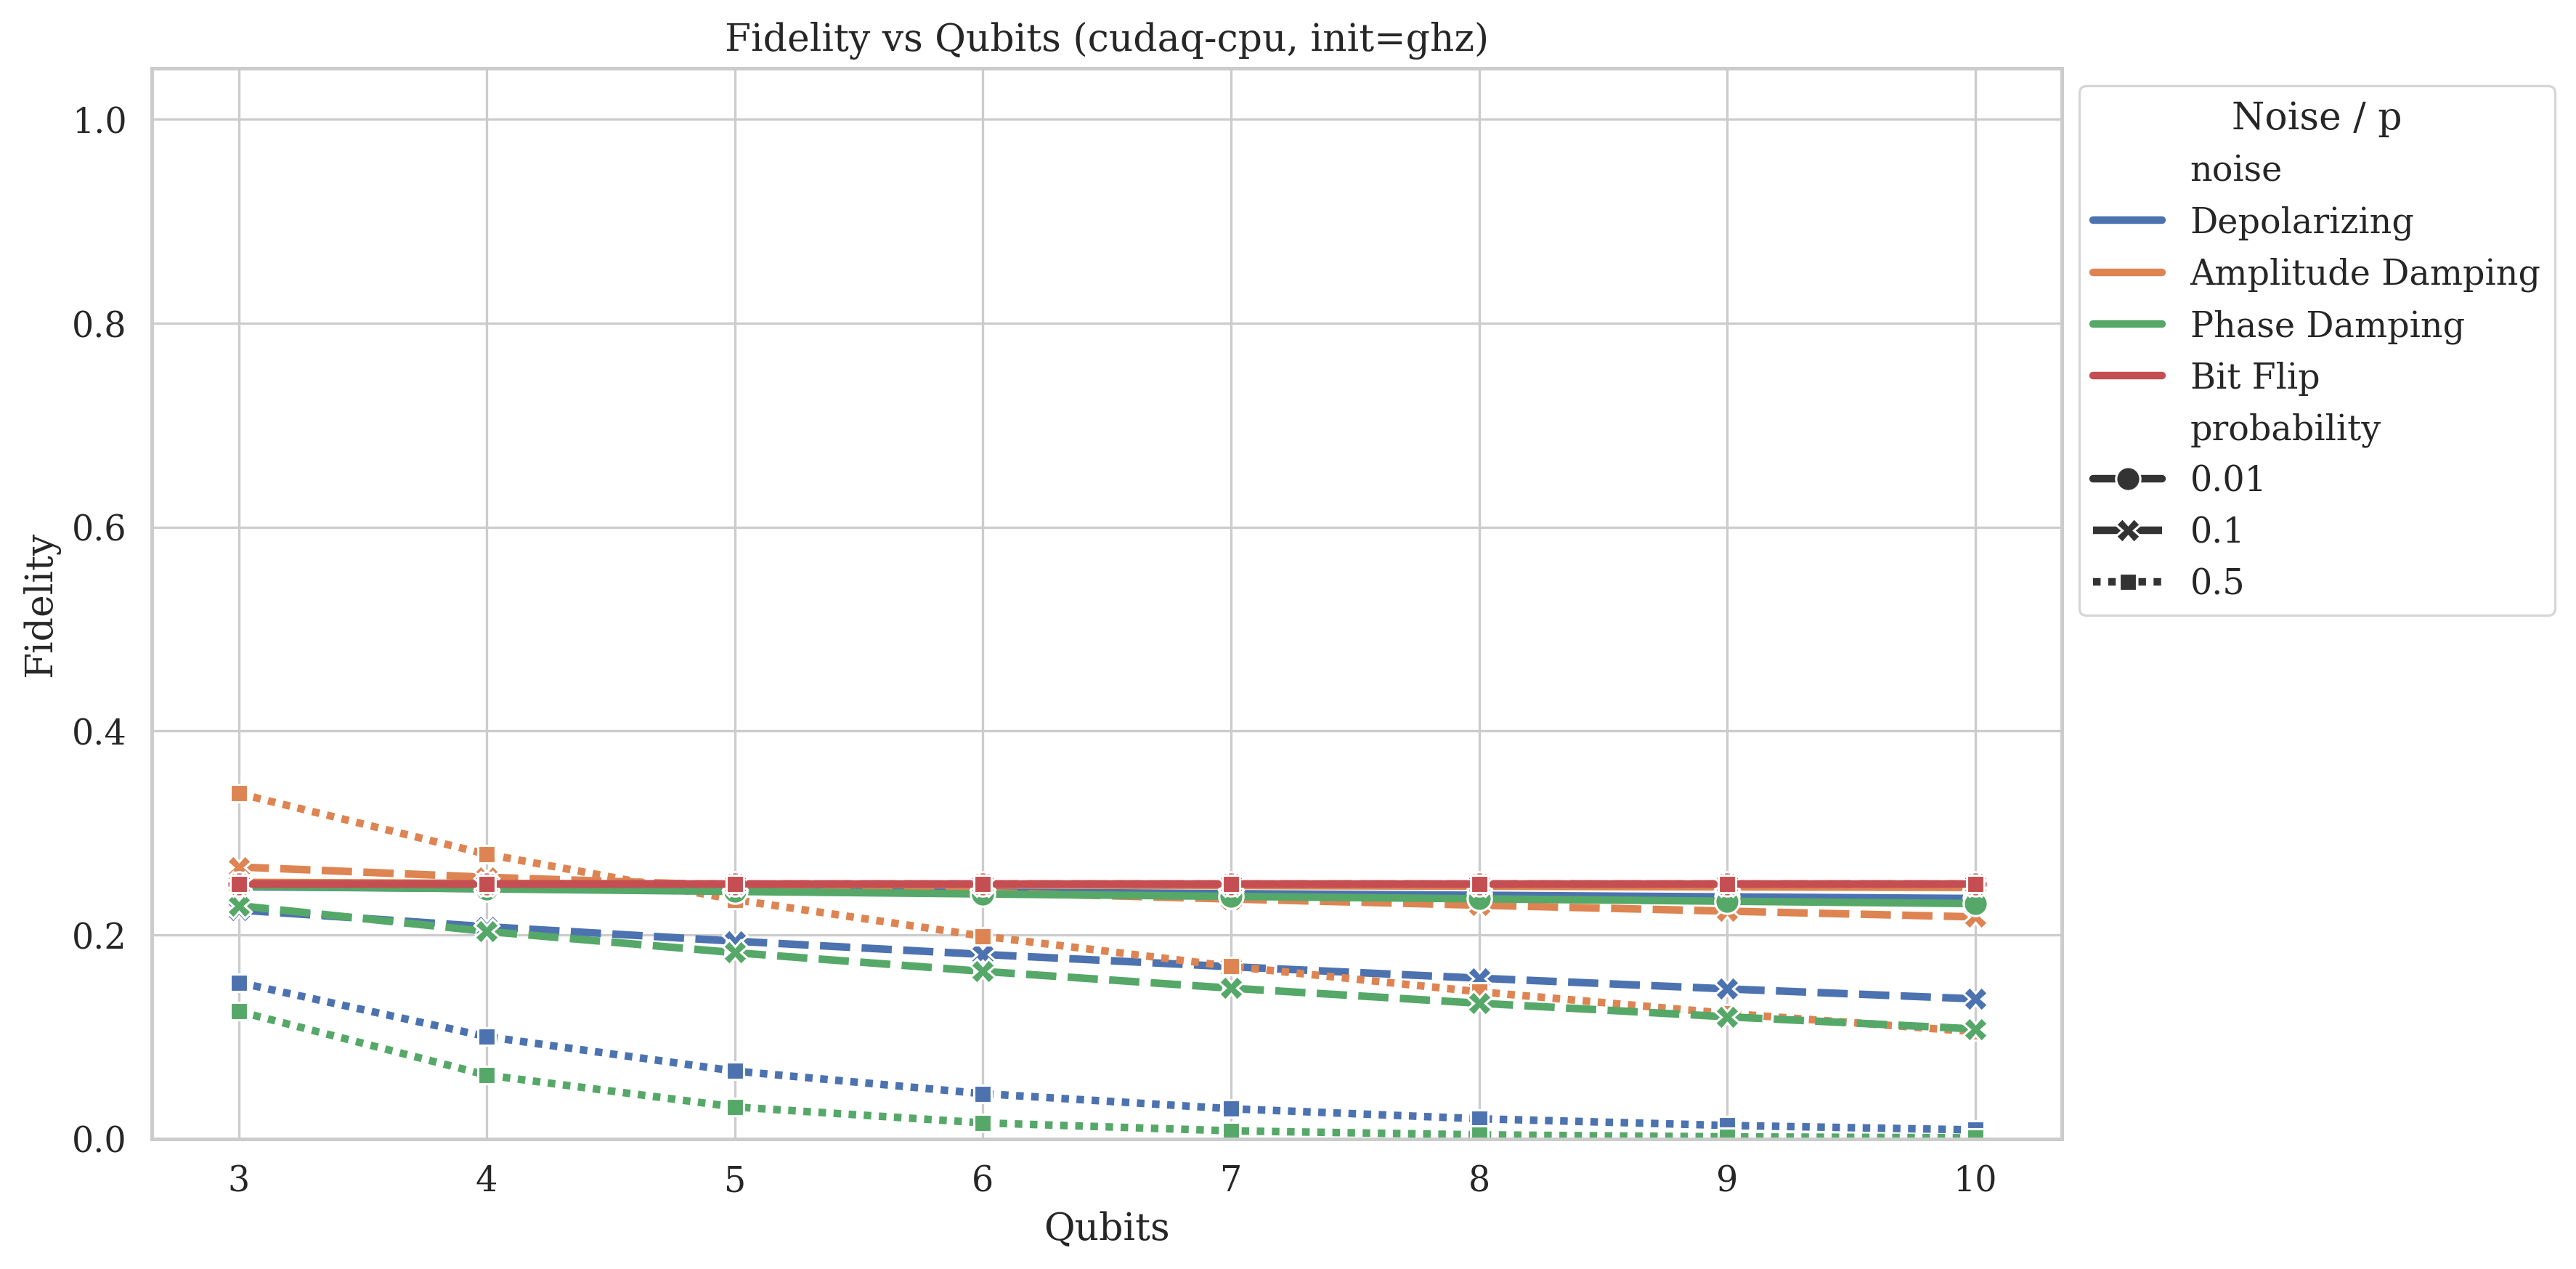

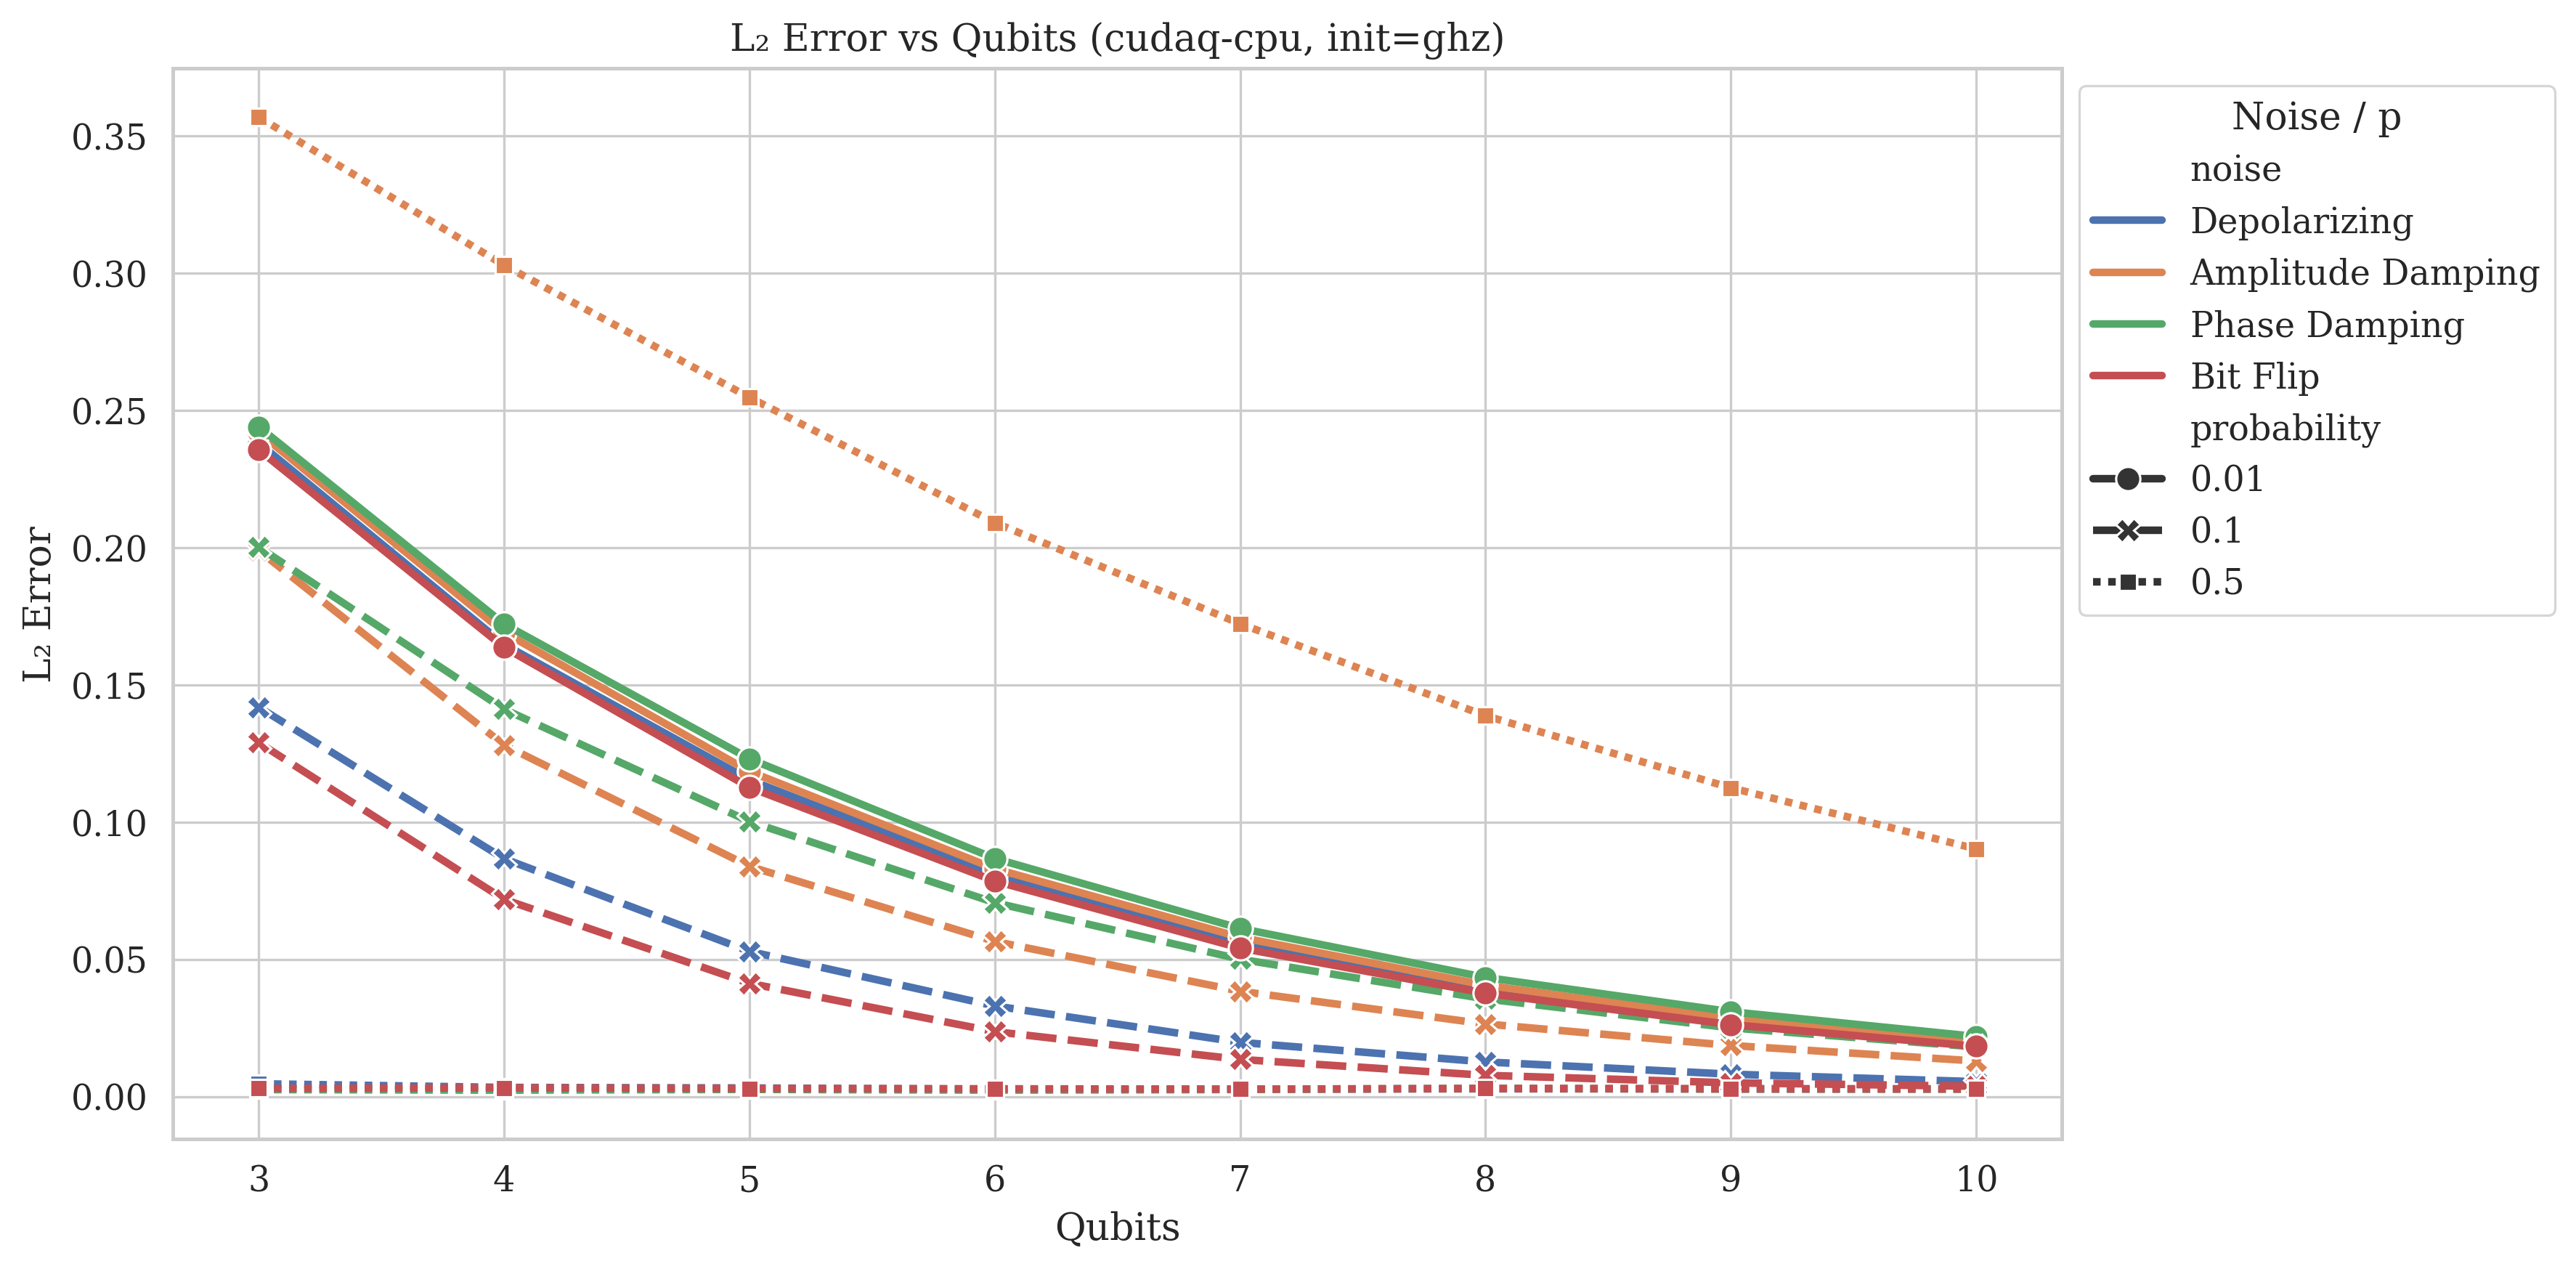

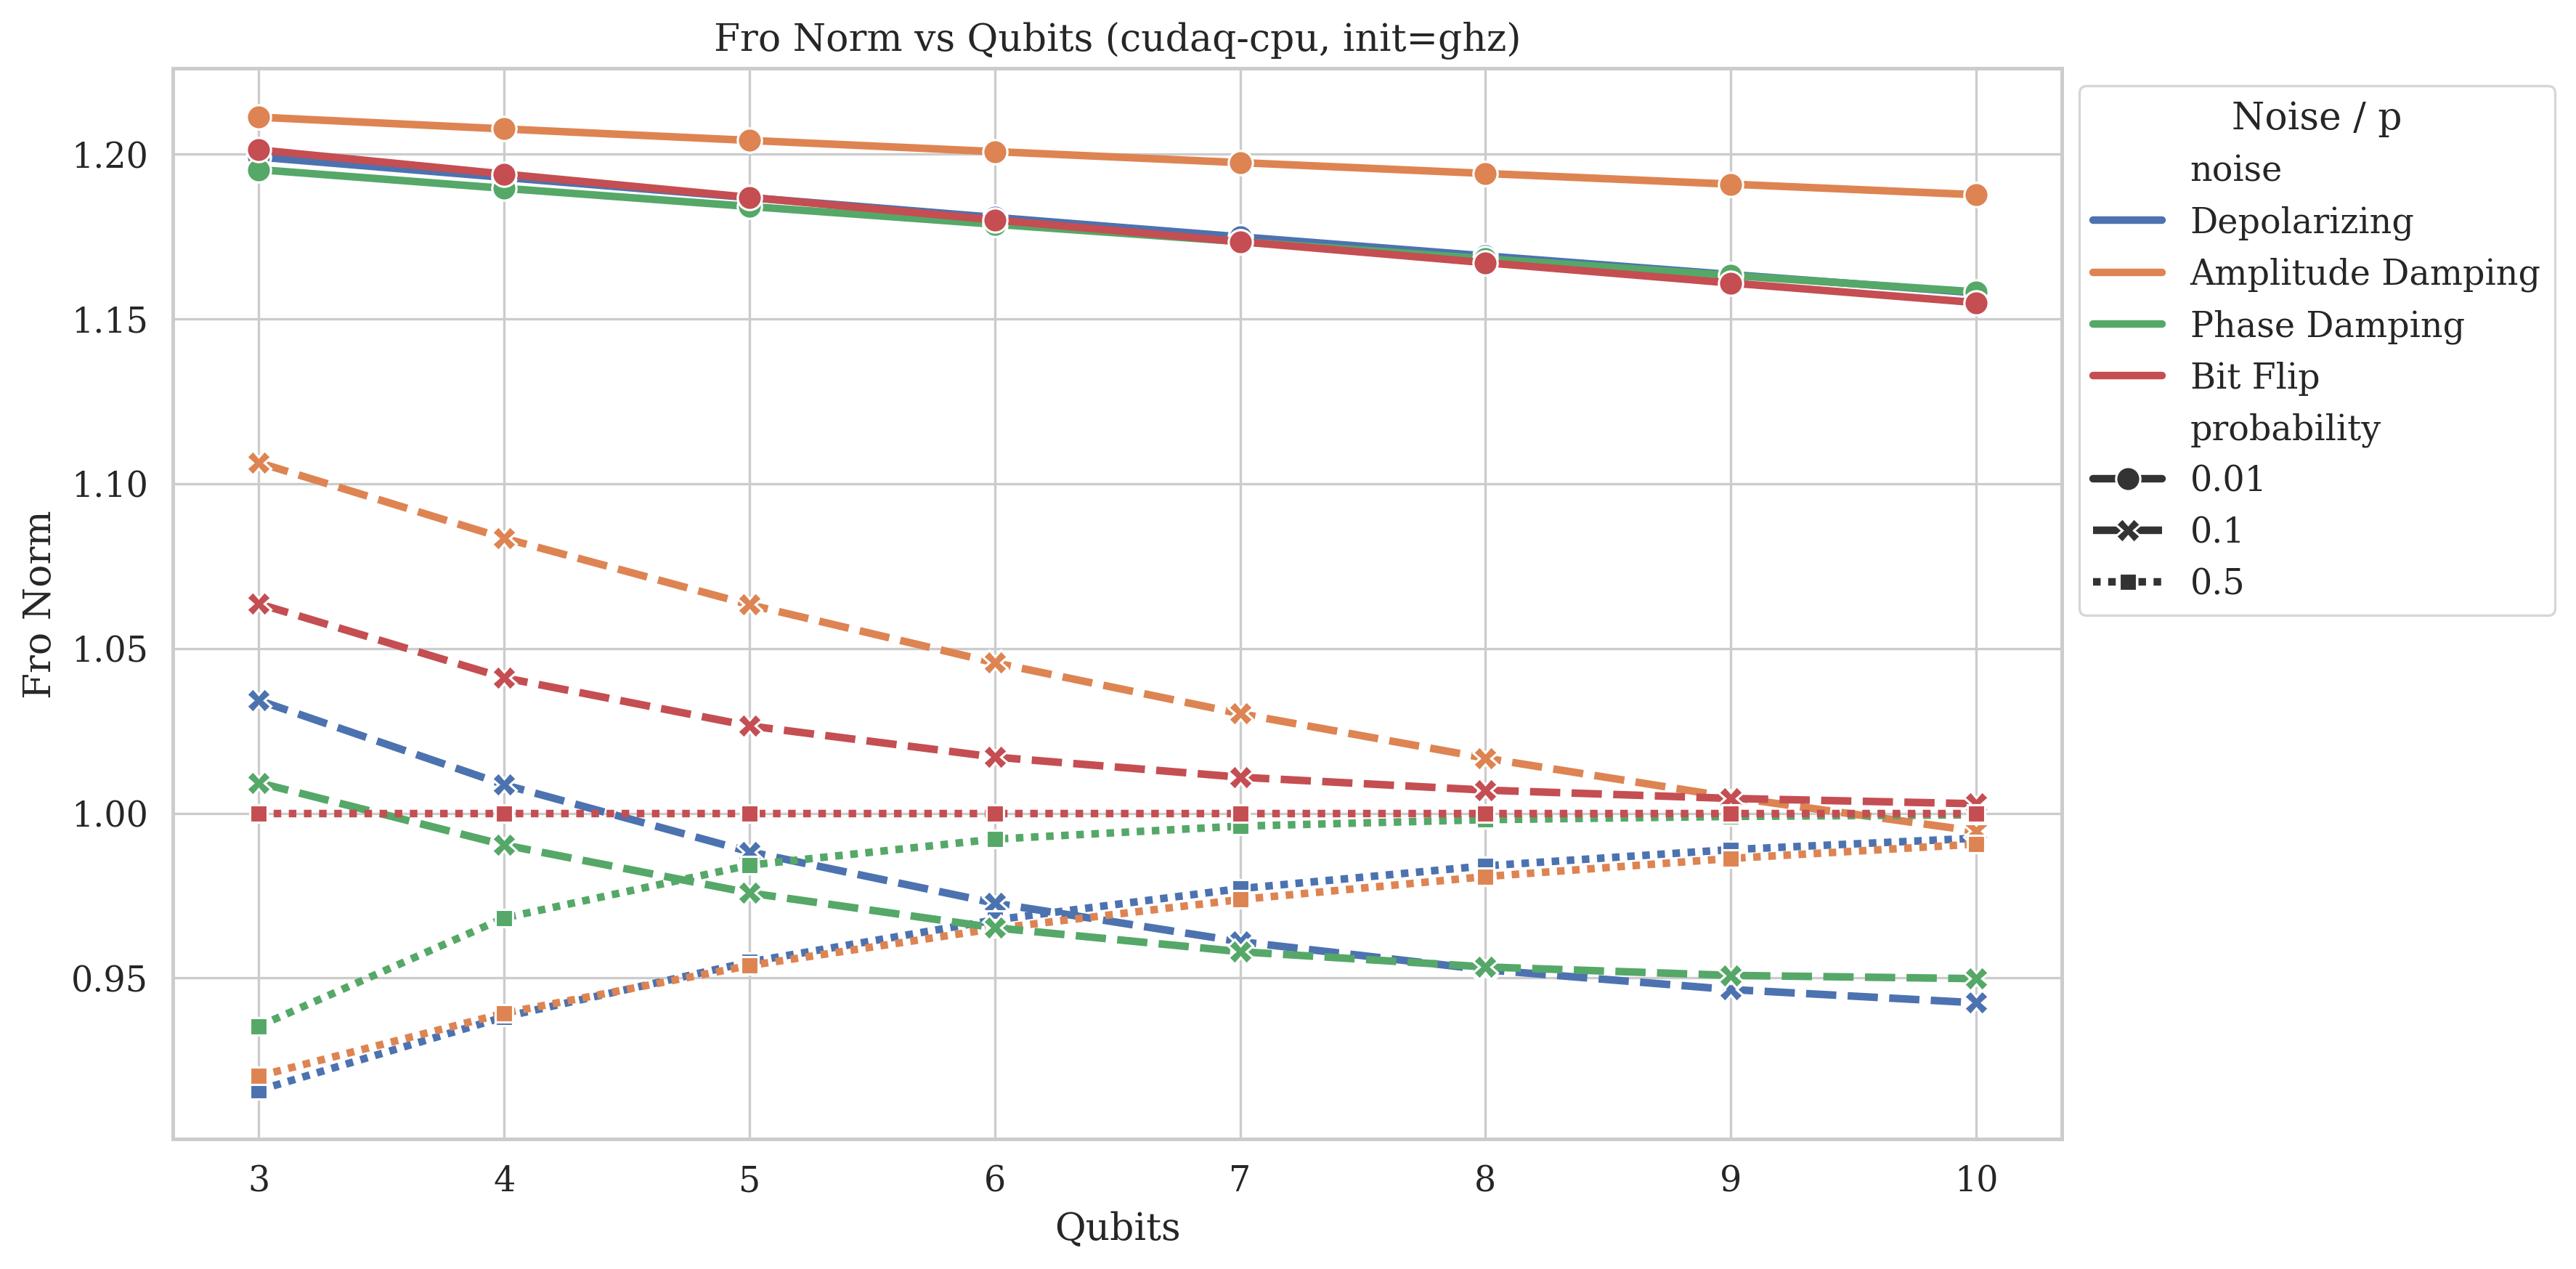

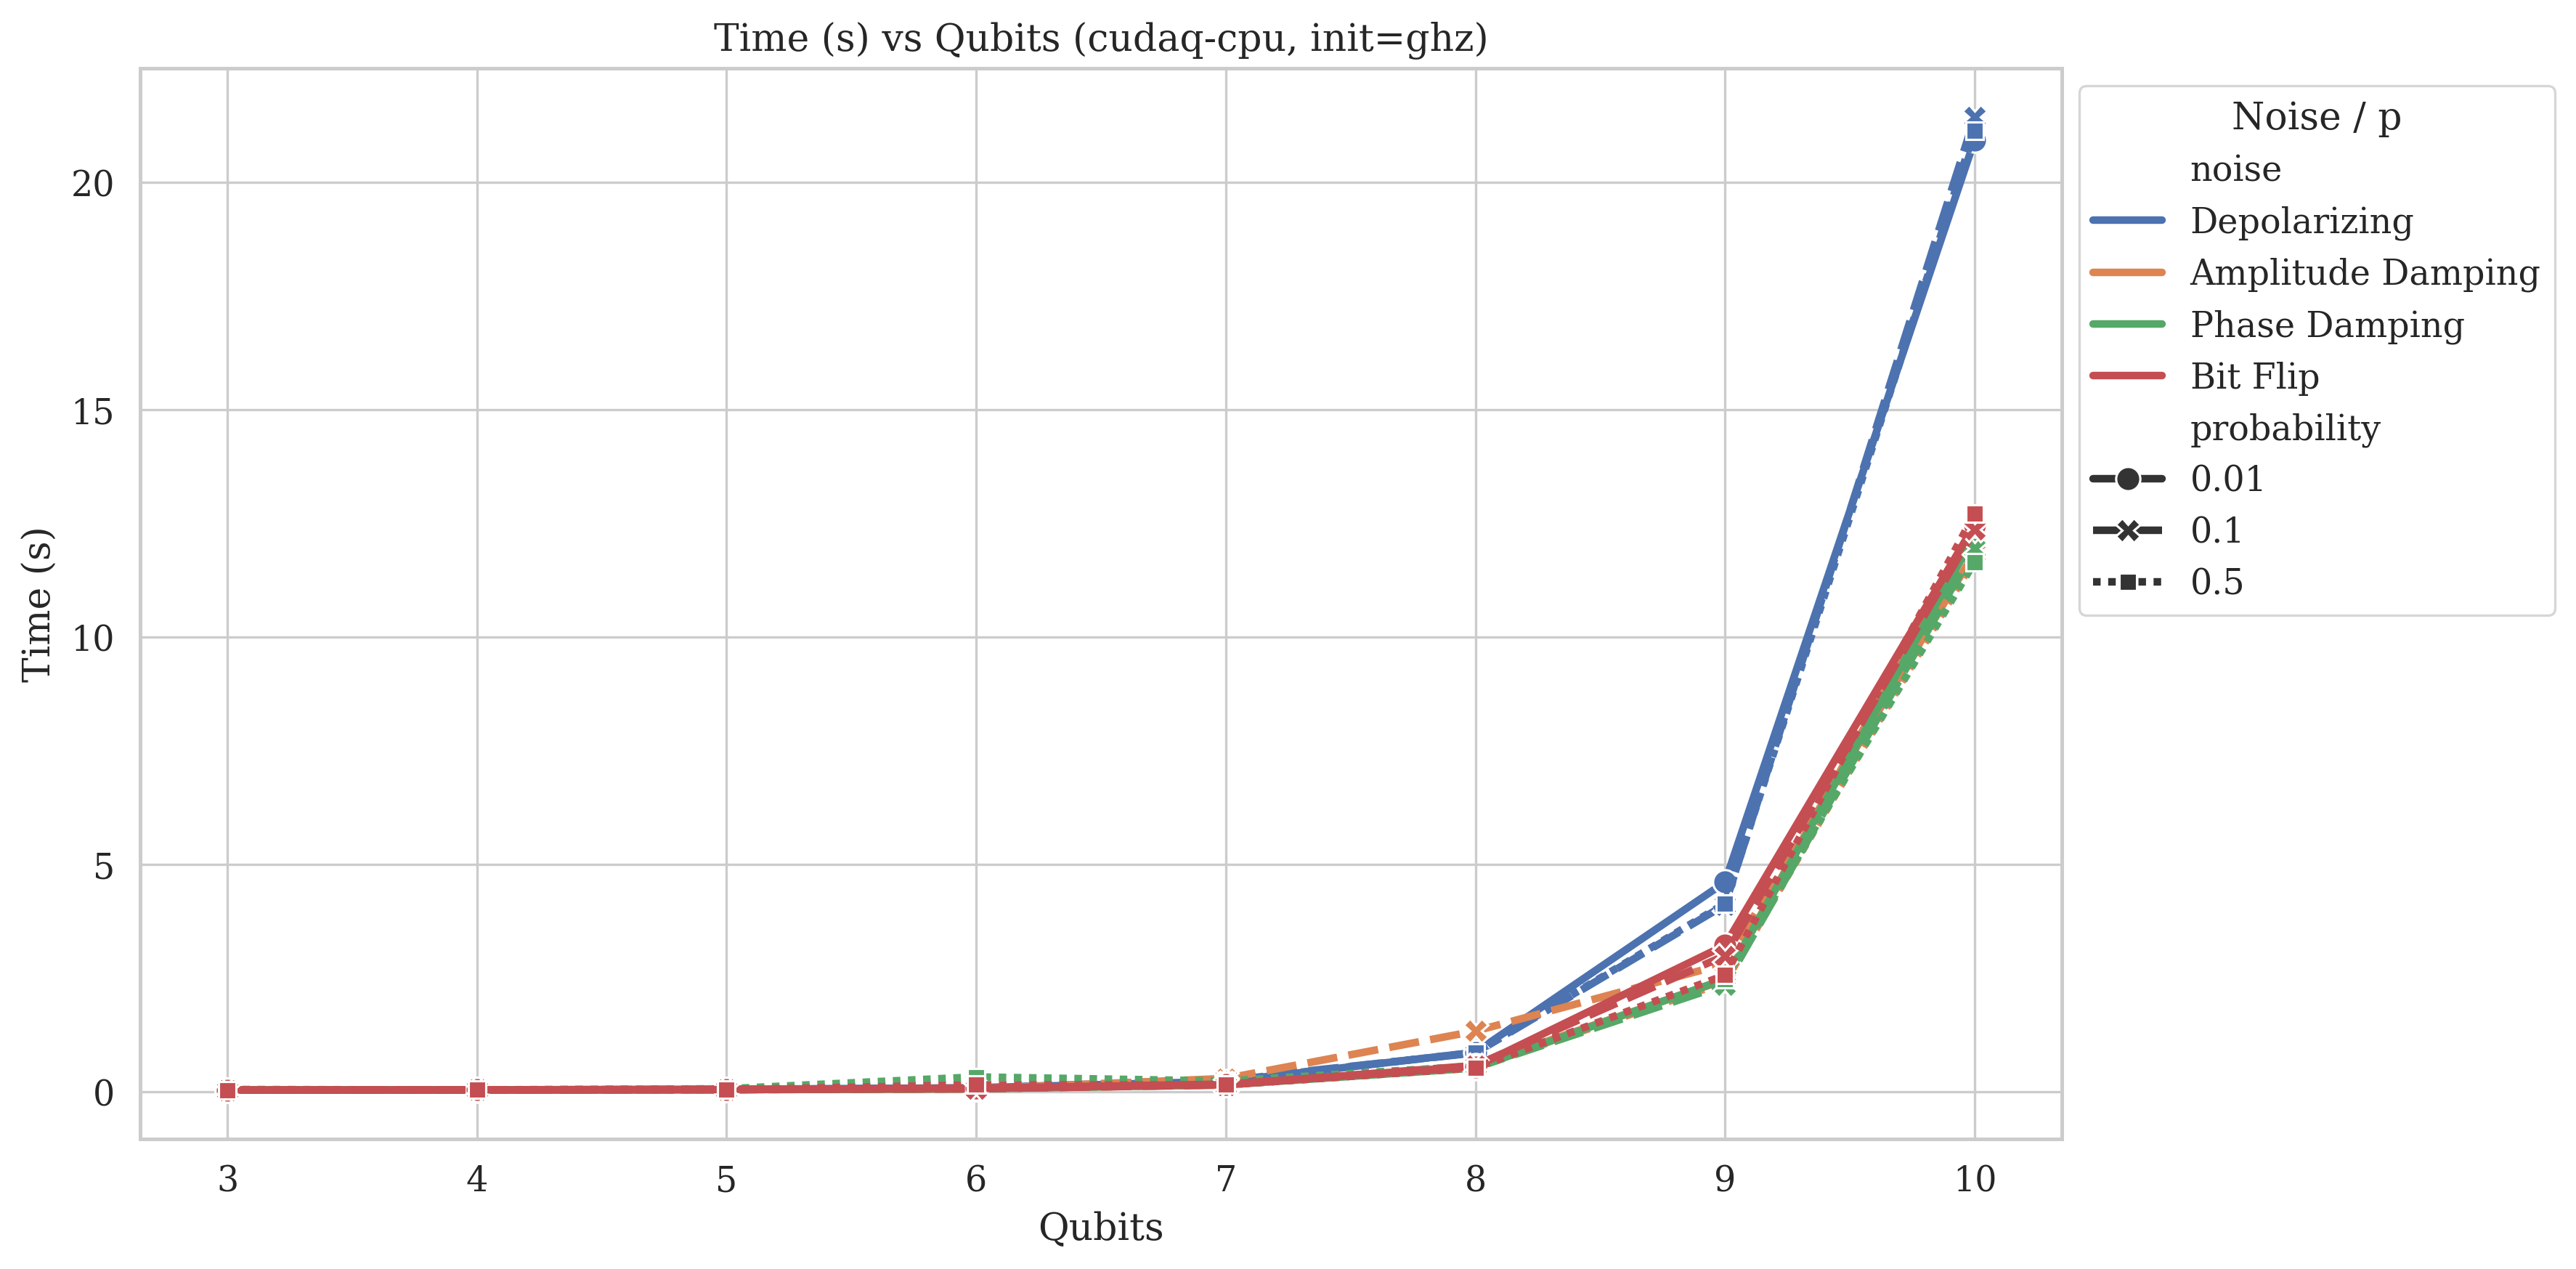

In [20]:
plot_noise_qubit_evolution(sim='cudaq-cpu', shots=131072)

### qiskit

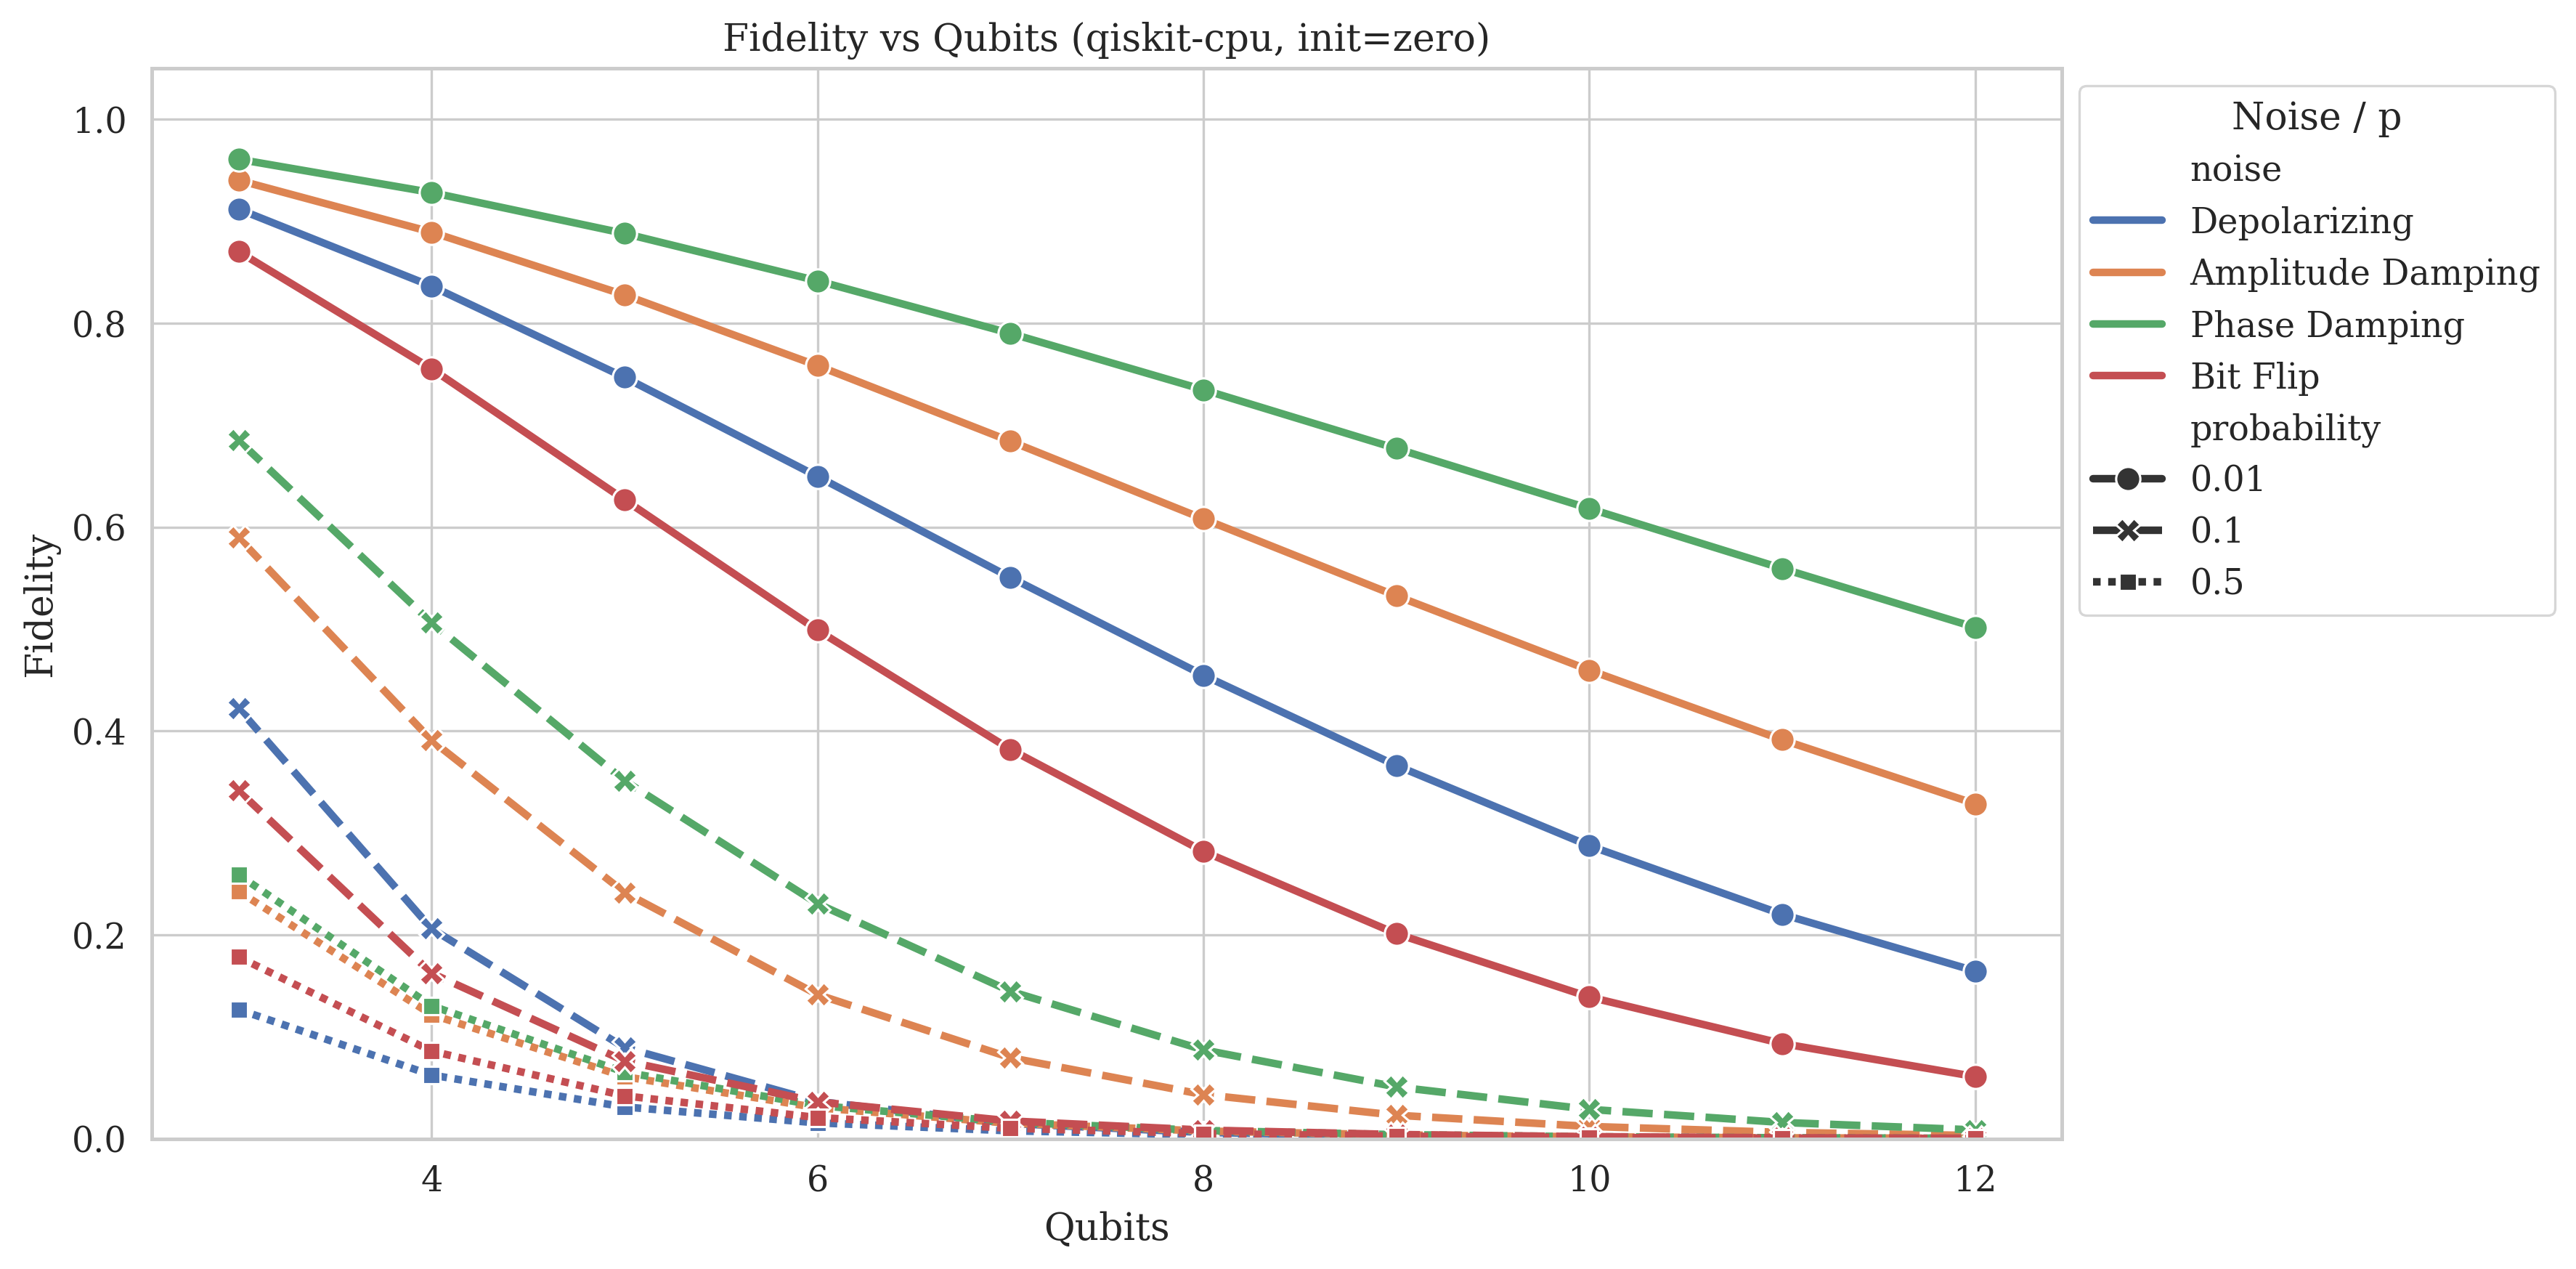

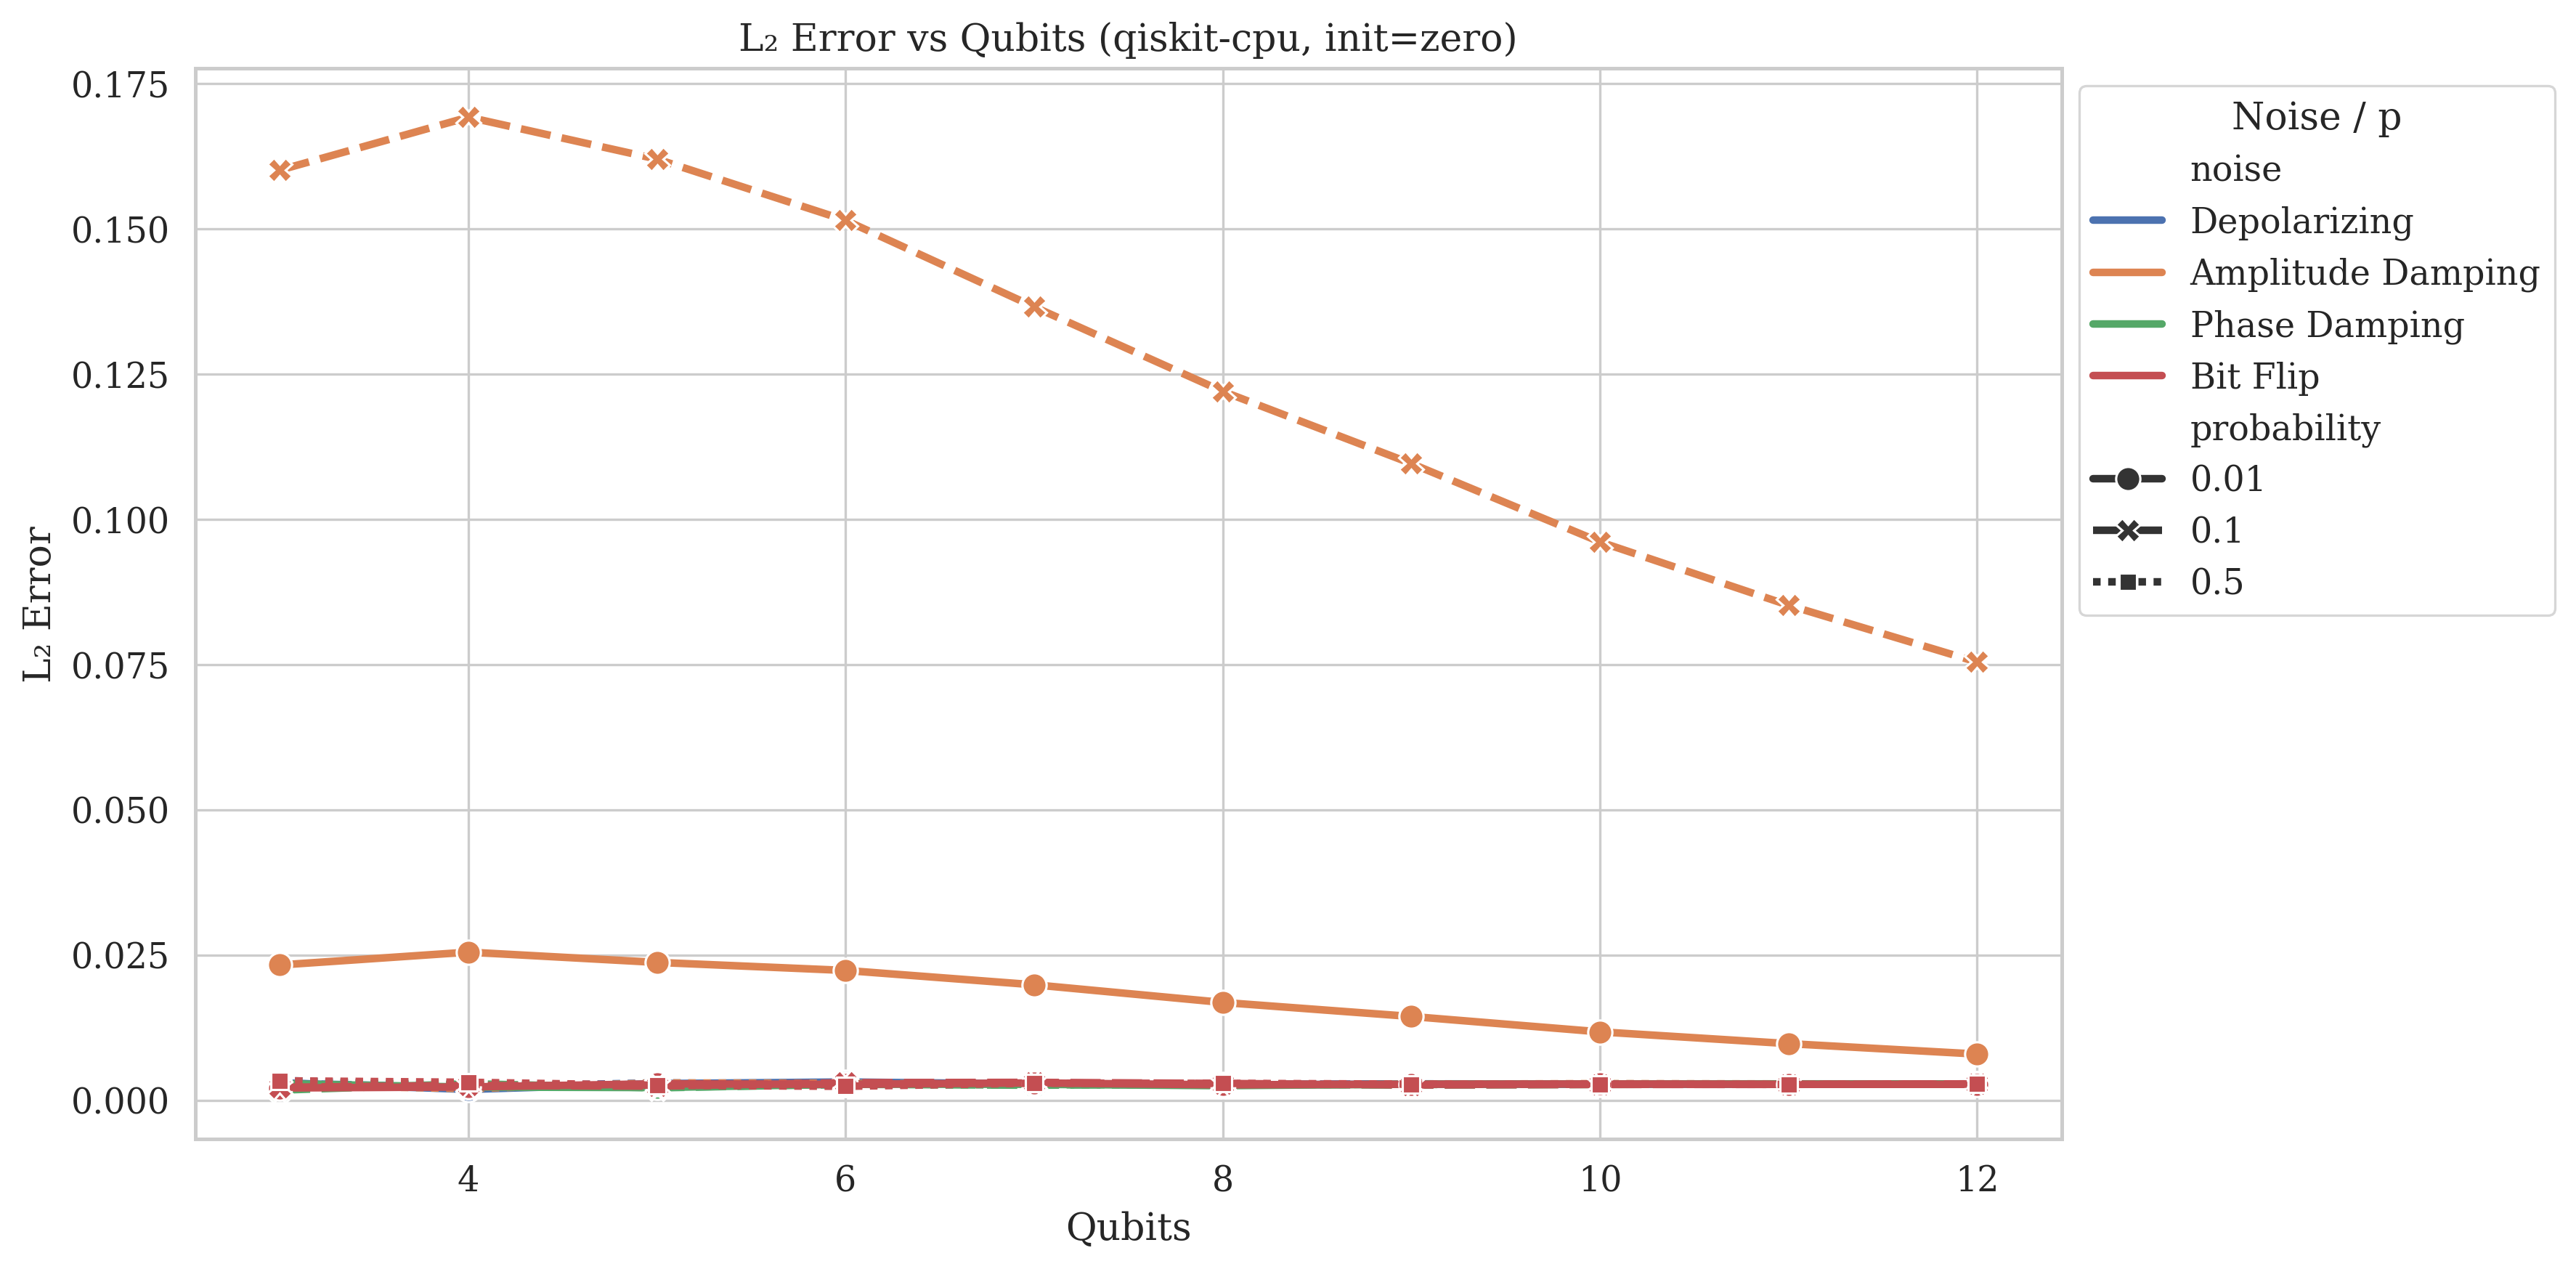

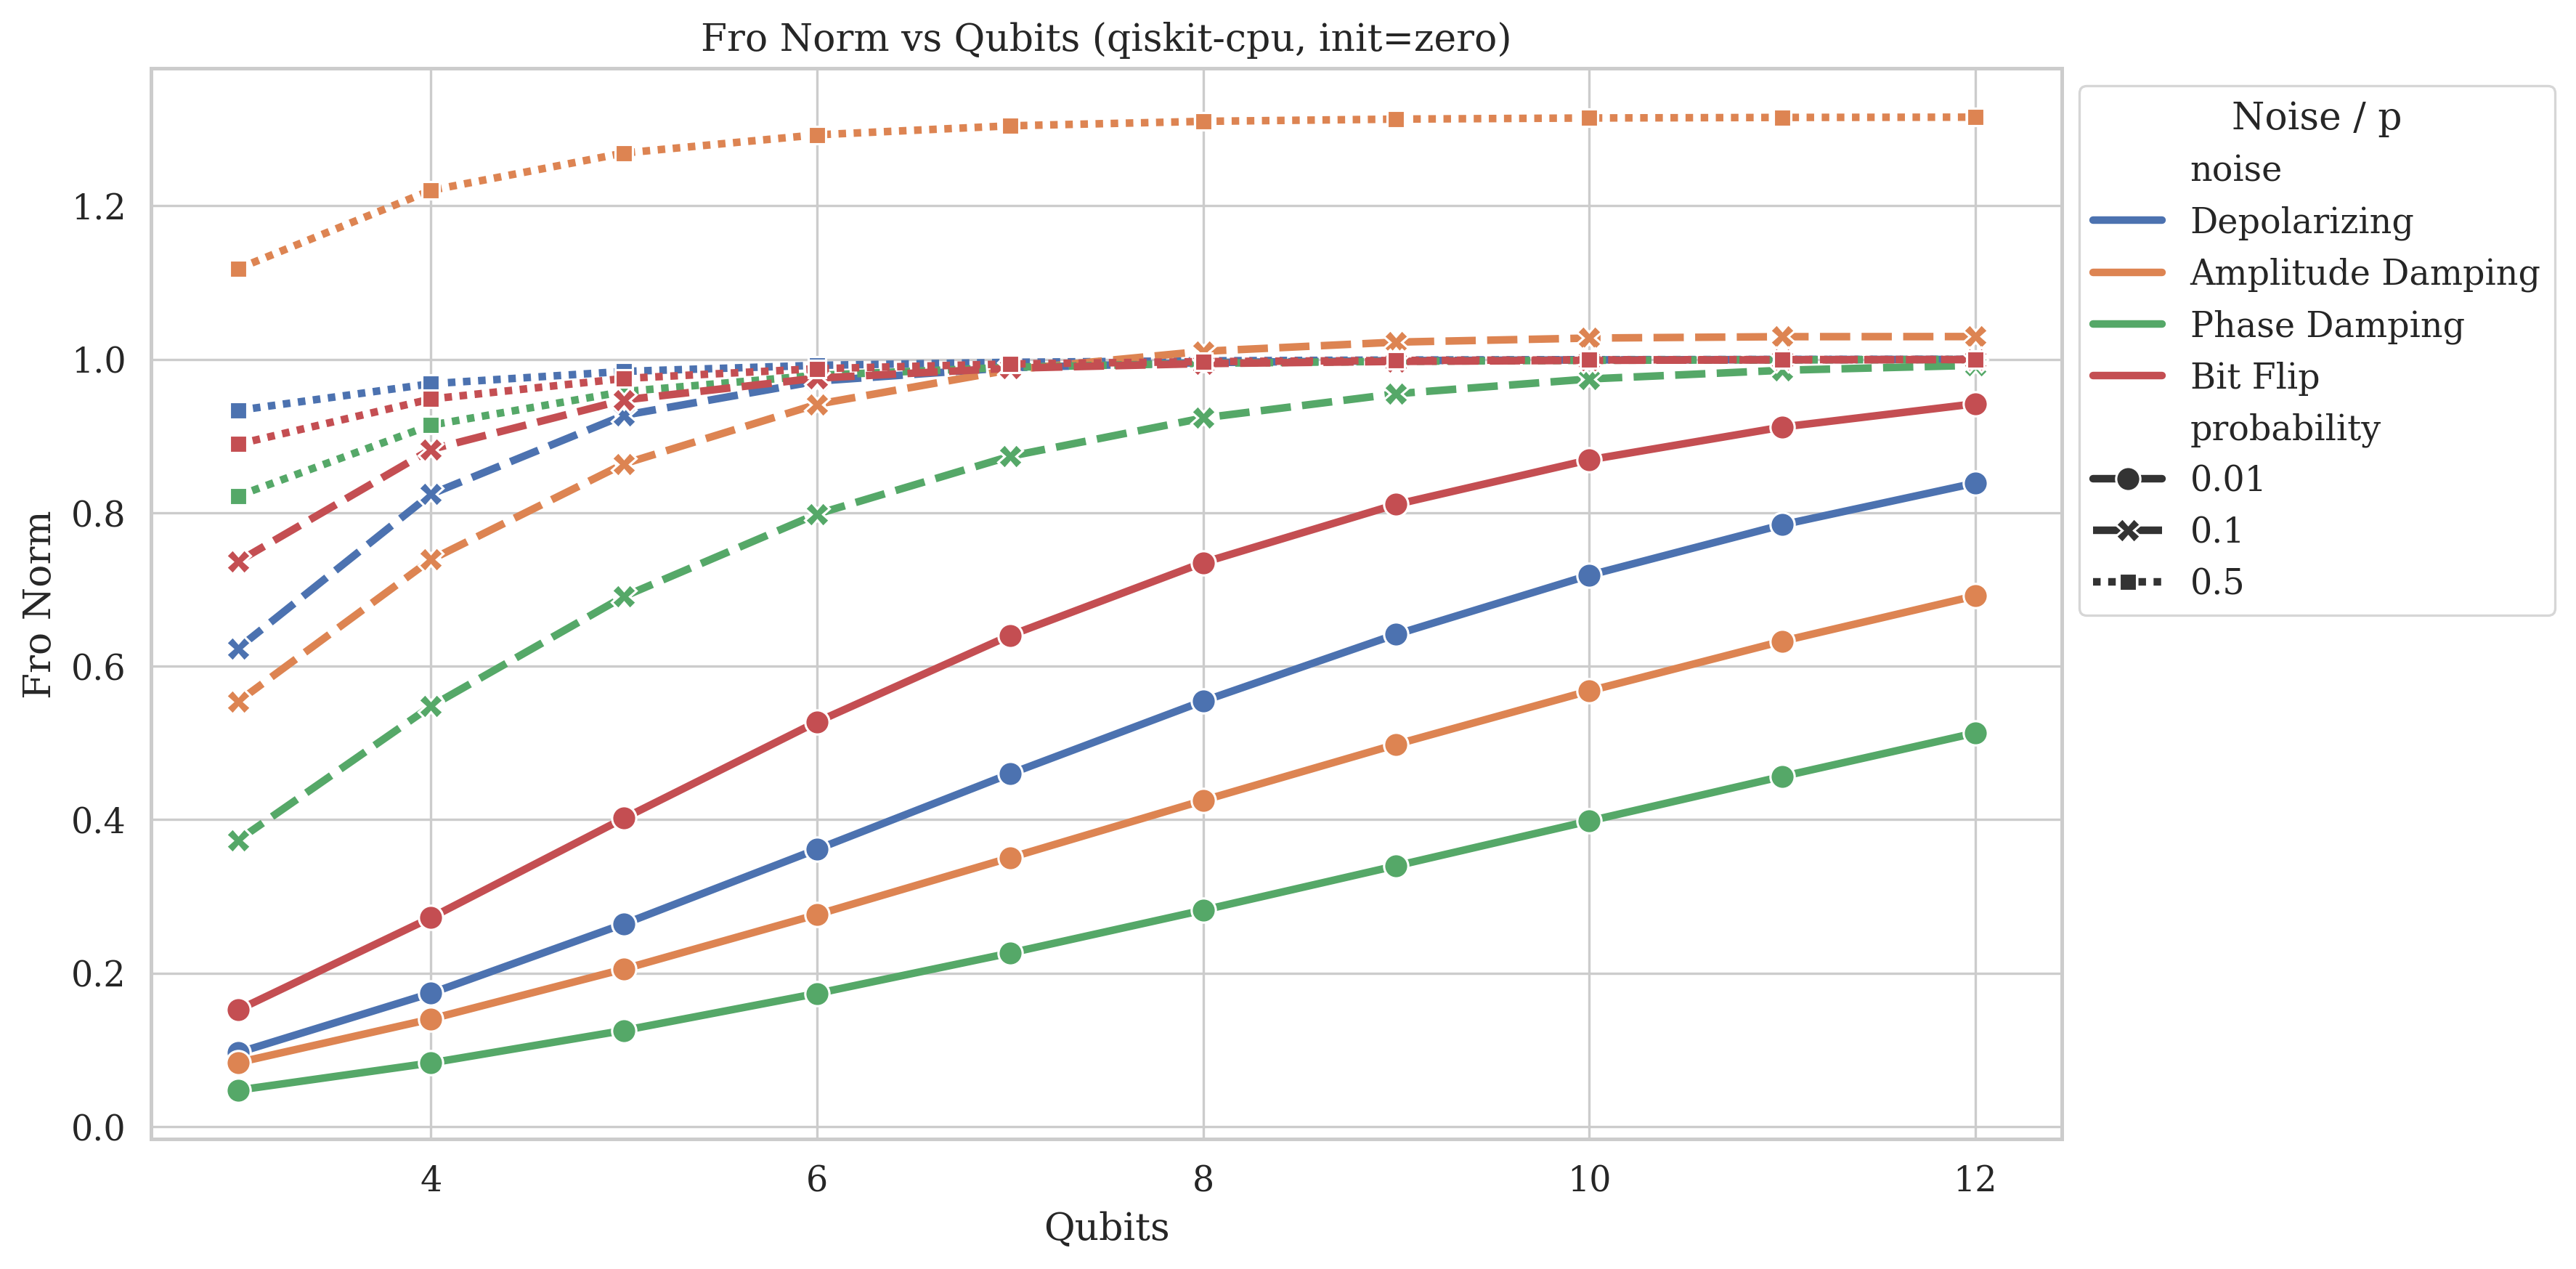

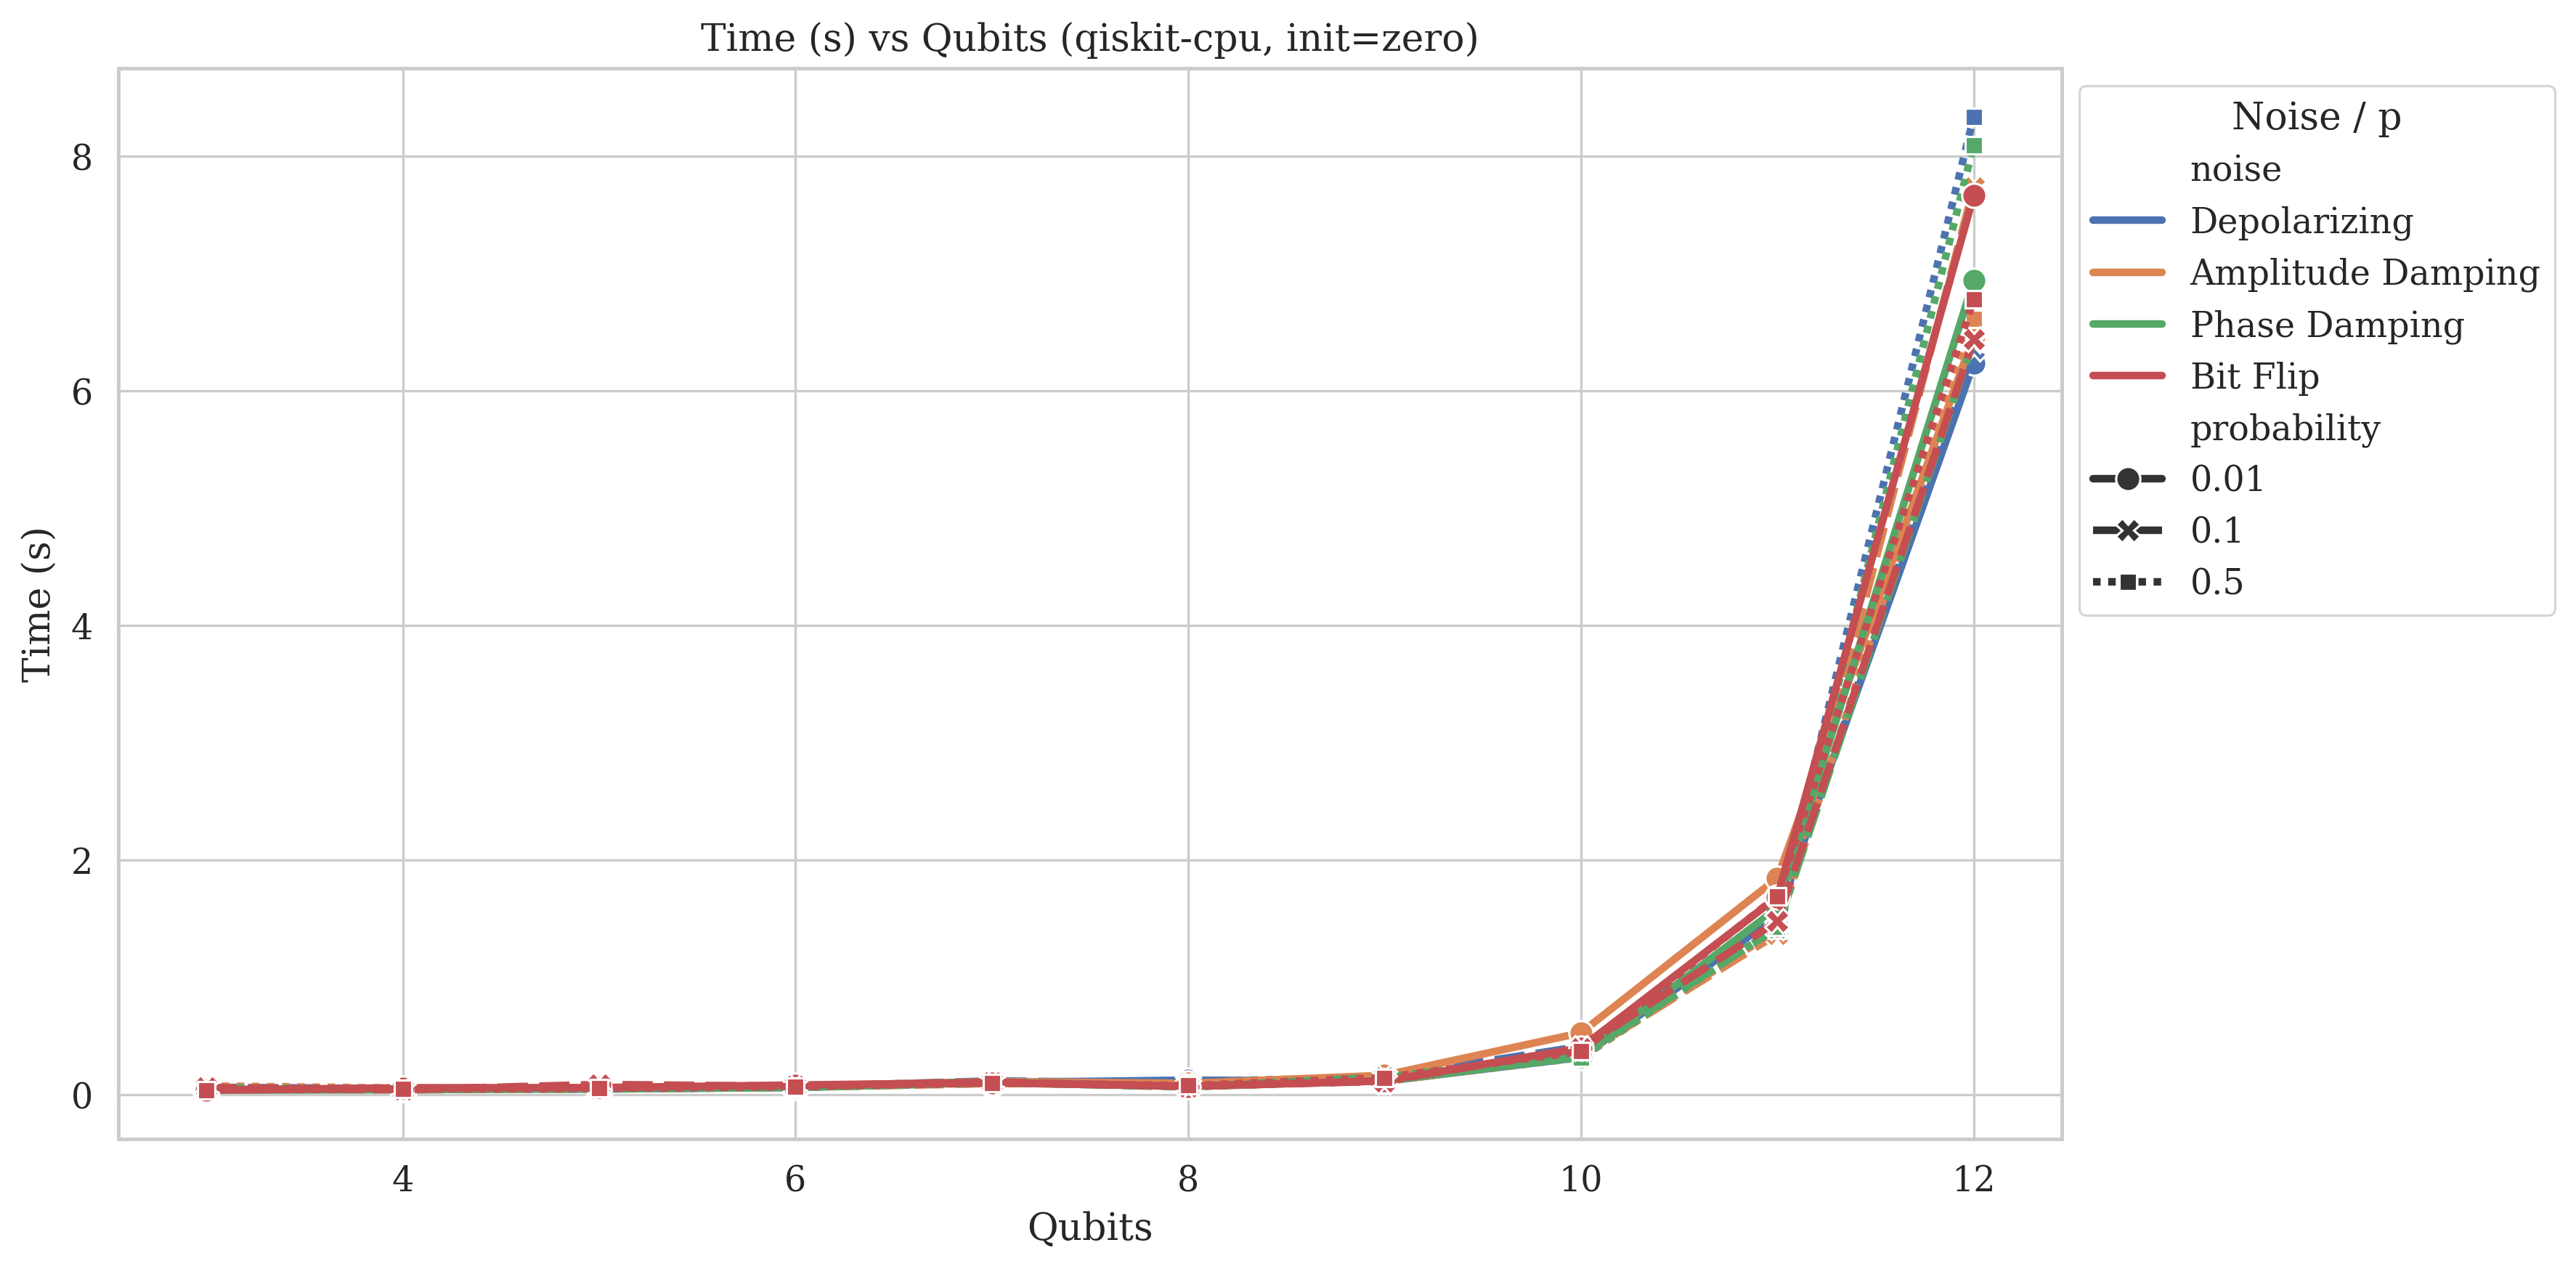

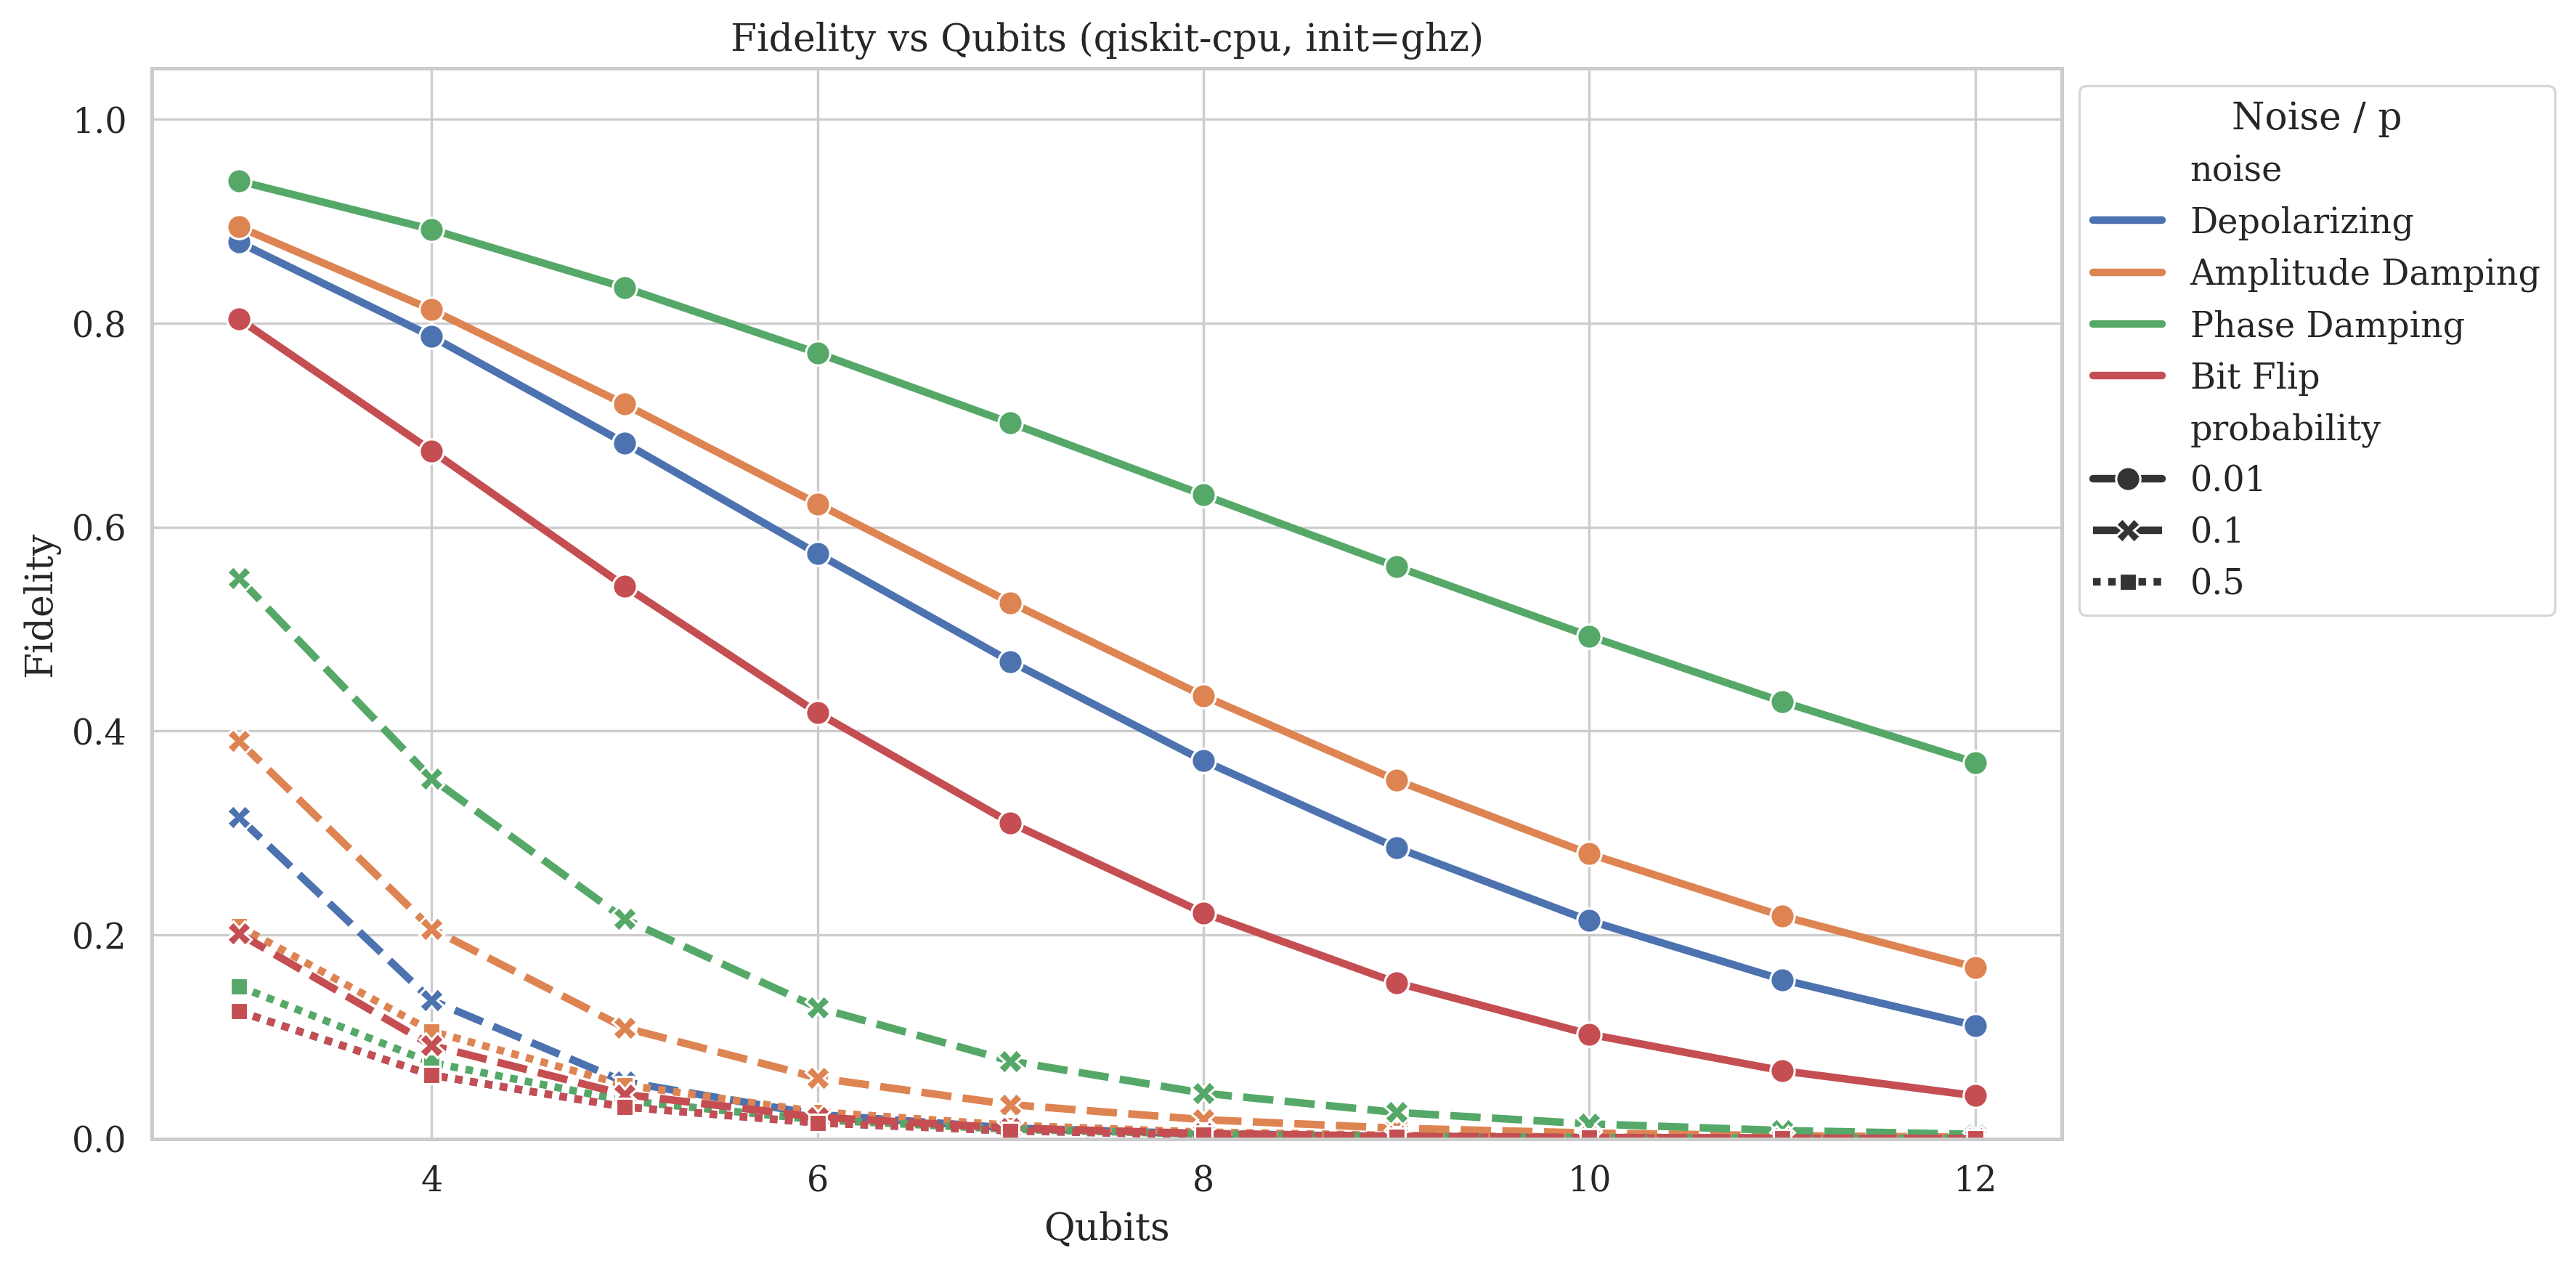

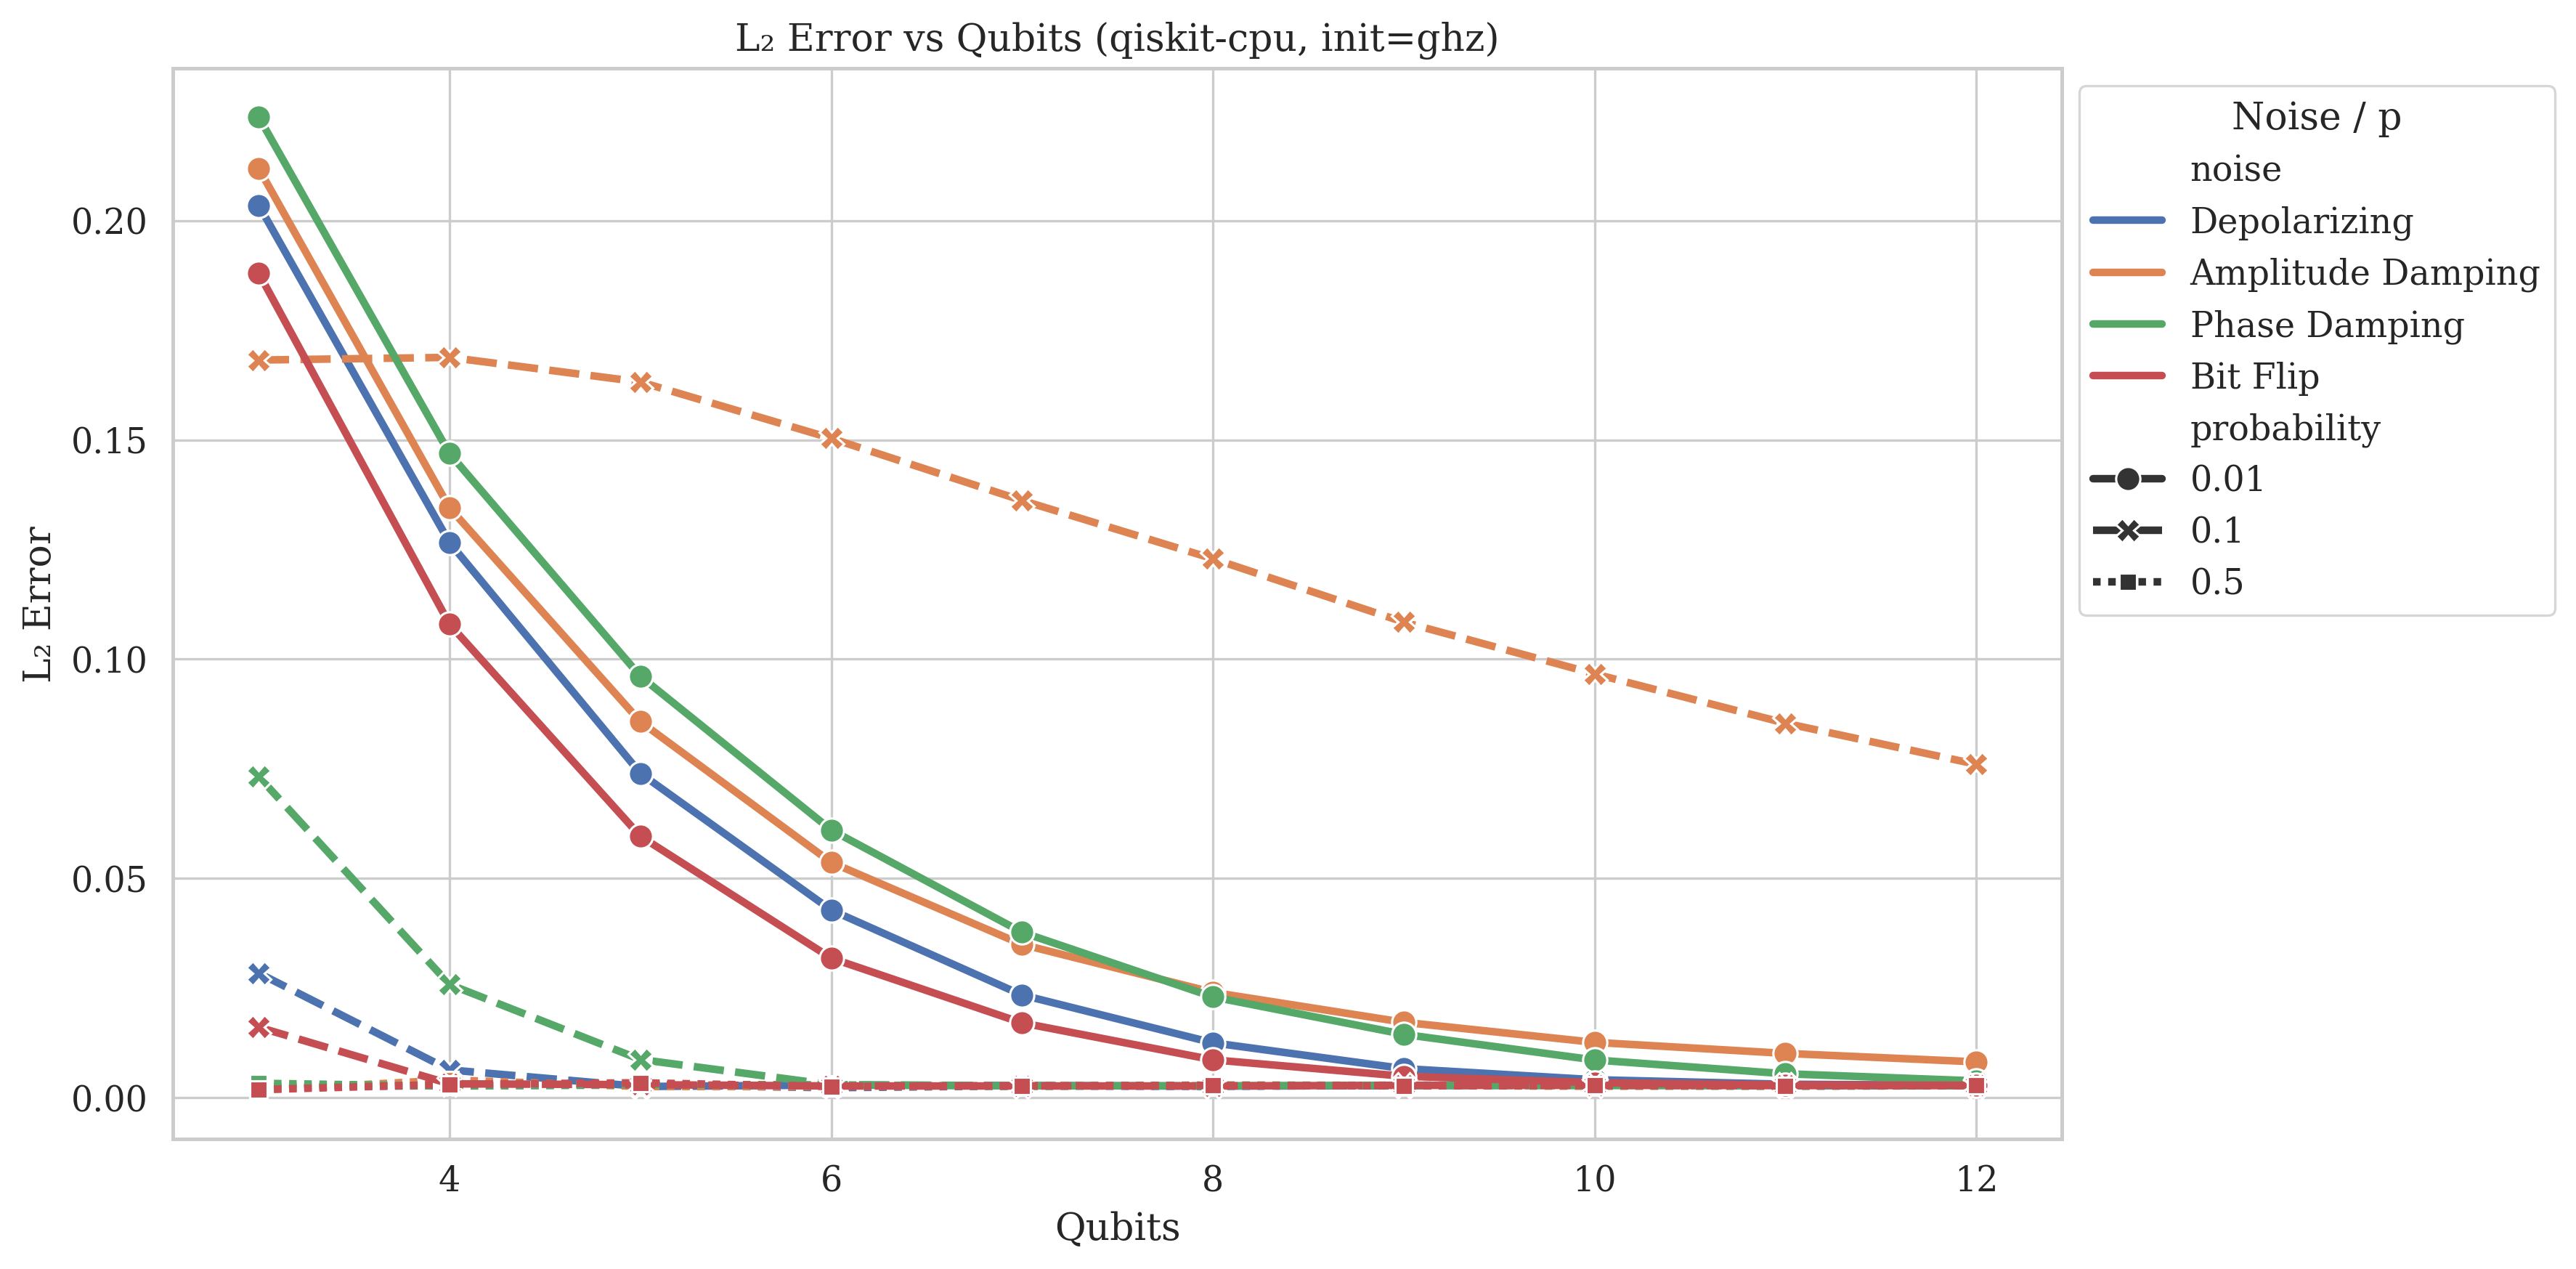

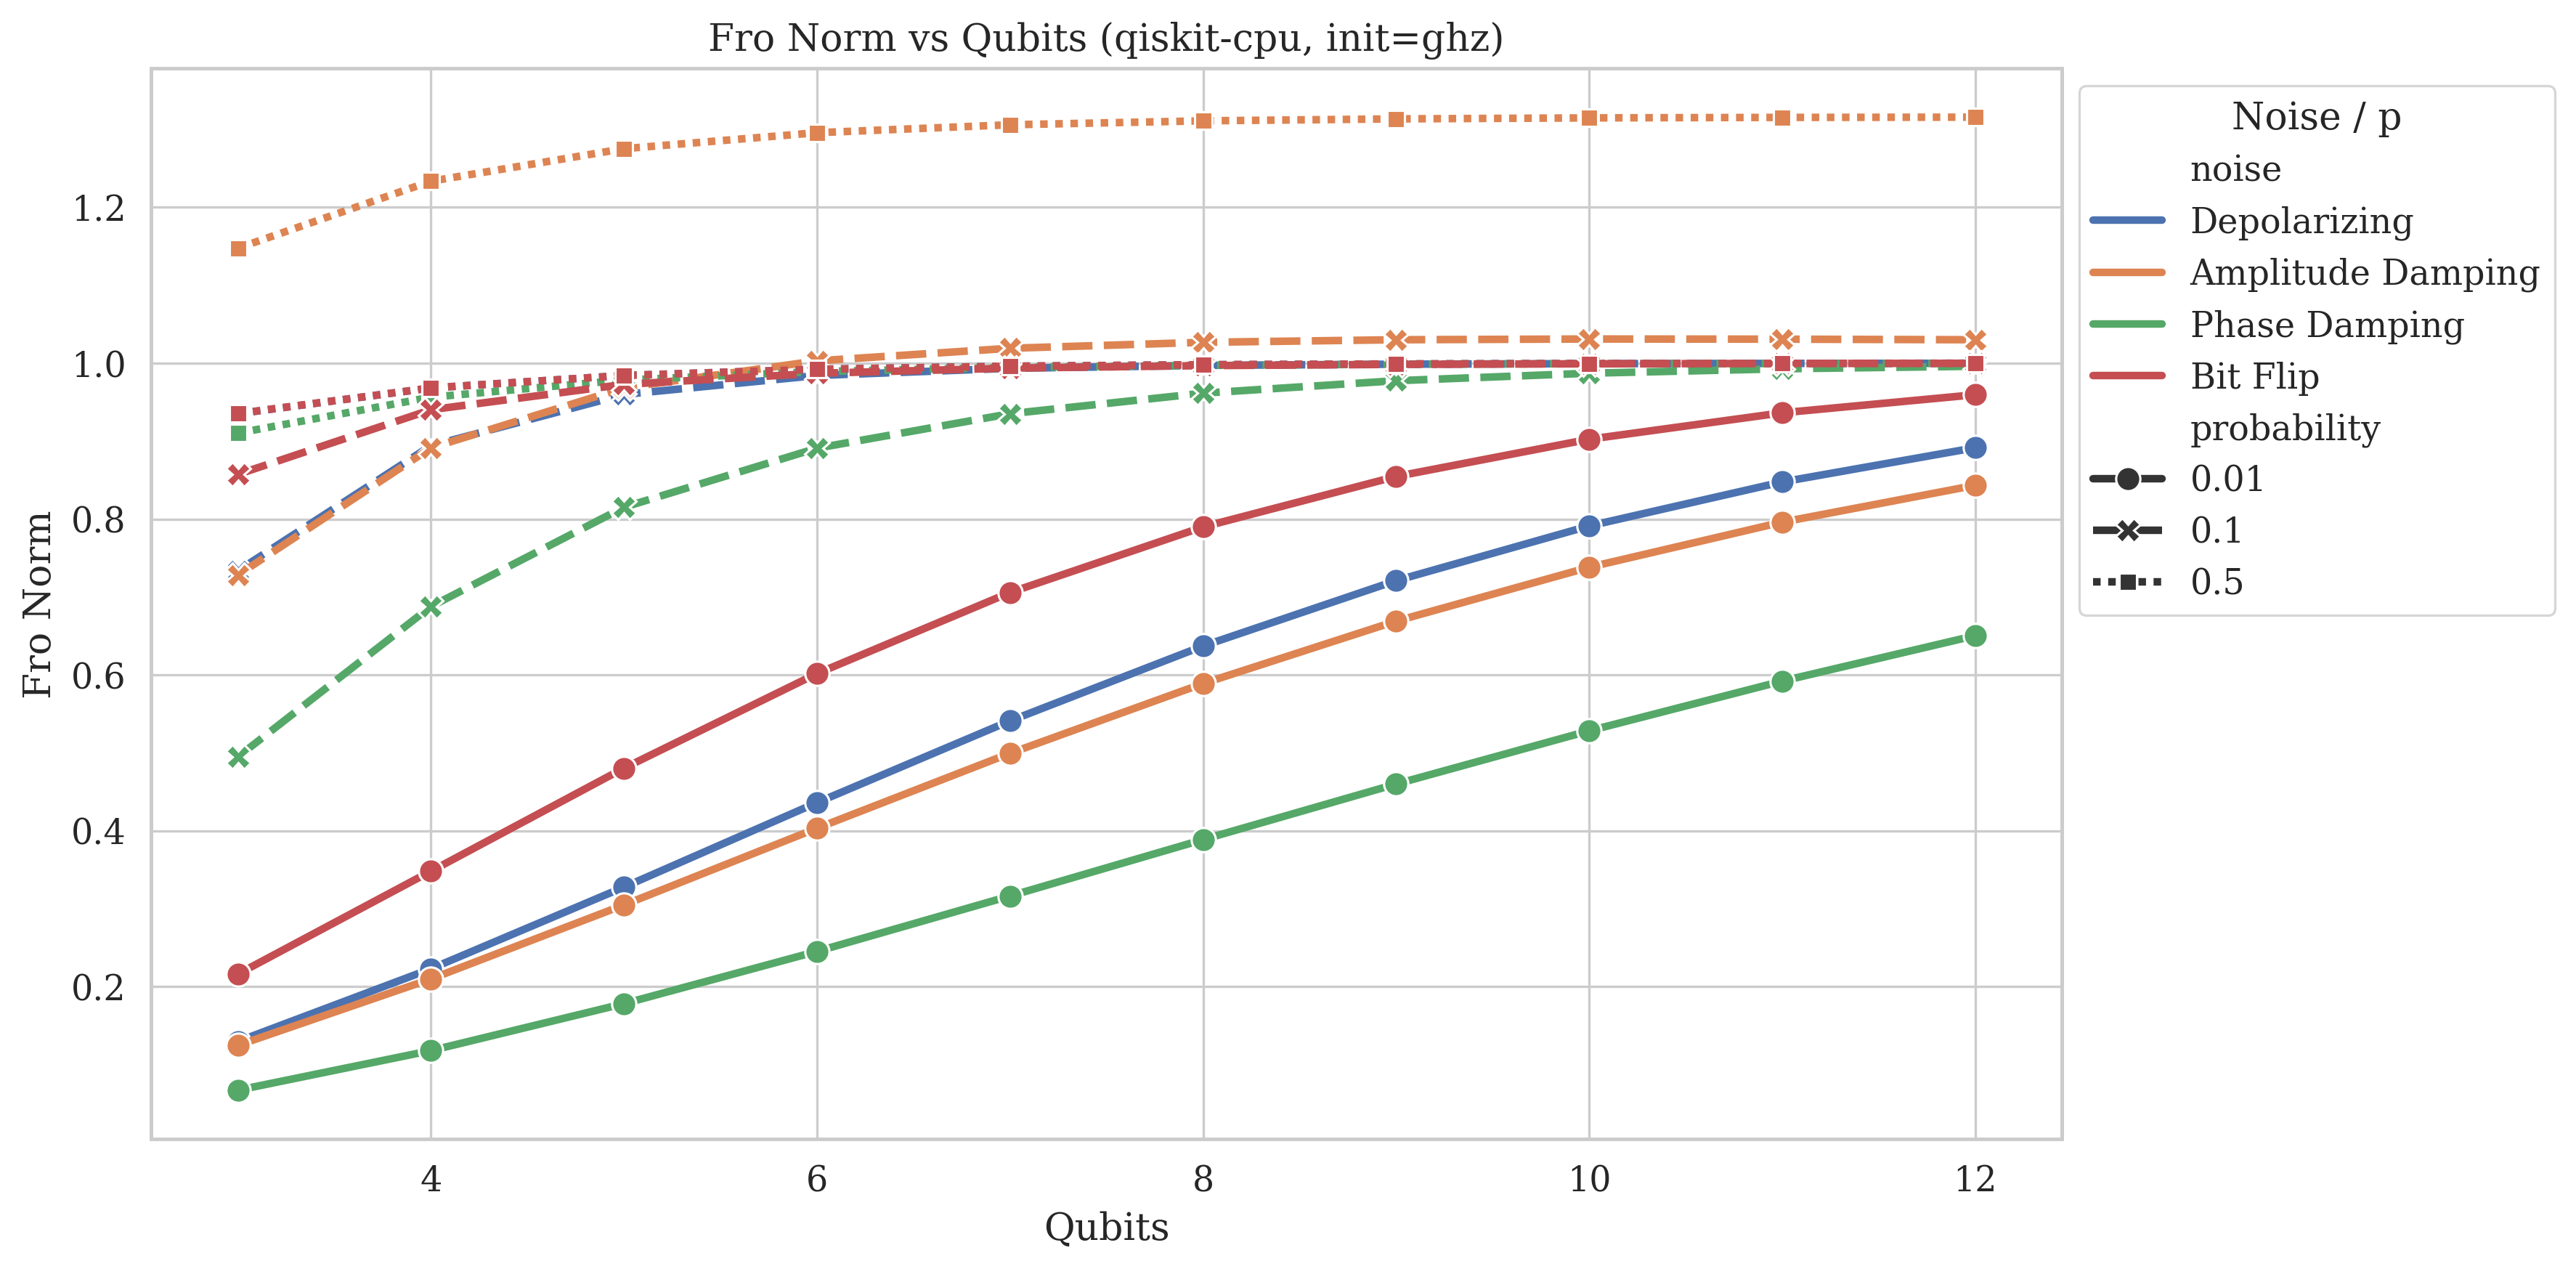

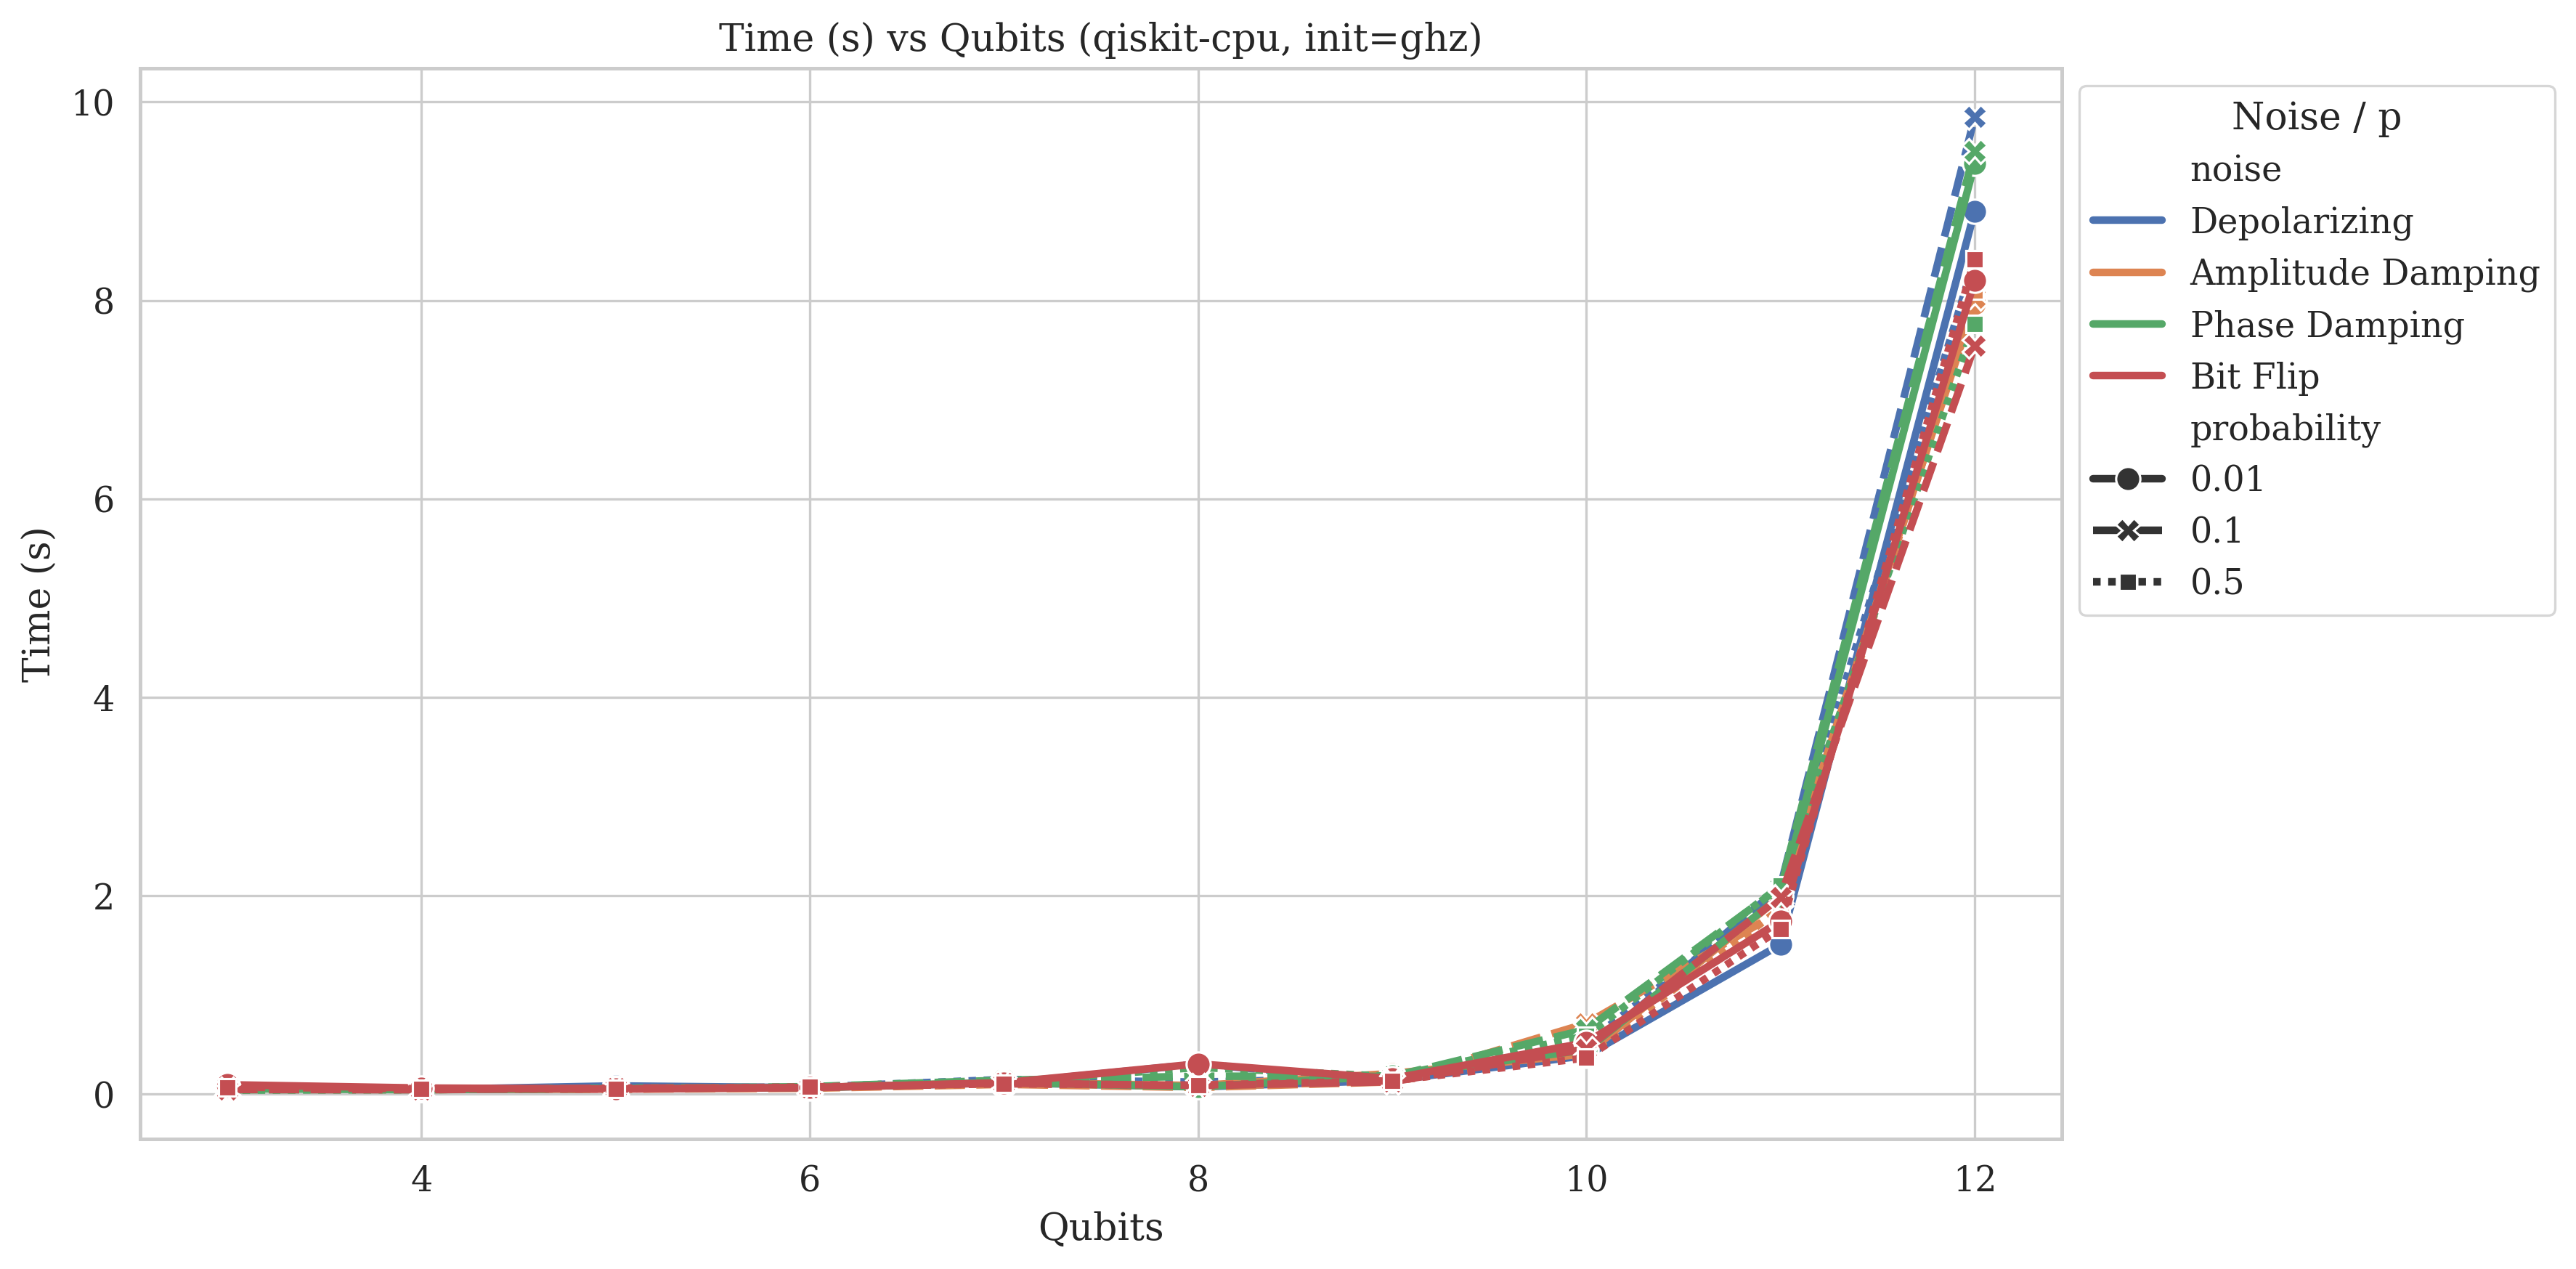

In [21]:
plot_noise_qubit_evolution(sim='qiskit-cpu', shots=131072)